<h1 id='logo'><img src='https://raw.githubusercontent.com/Camilorb07/Integrador_S1_2021/main/Imagenes/Logo_EAFIT.png' width='350'  /></h1>

<hr style='border:2px solid #004B85'> </hr>


## Modelo predicitivo de desgaste (intención de renuncia) de empleados de la compañia IBM (Scope: Clasificación)

<hr style='border:2px solid #004B85'> </hr>

# Machine Learning Aplicado
## Semestre 2025-2

- #### Andrea Paola Alzate Ramirez
- #### Gustavo Adolfo Jerez Tous

<hr style='border:2px solid #004B85'> </hr>


- Este notebook fue desarrollado en Google Colab.

In [4]:
%load_ext autoreload
%autoreload 2

import sys
import warnings
warnings.filterwarnings('ignore')

<hr style='border:10px solid #004B85'> </hr>
<div align='center'>
  <font size ='20' style='color:red'><b>ENTREGA 3: RESULTADOS DE ENTRENAMIENTO</b>
</div>

<hr style='border:10px solid #004B85'> </hr>

Para esta entrega, se parte de los resultados del EDA y baseline realizados anteriormente, para proceder a la ingeniería de características y tuneo y validación de modelos.

<hr style='border:10px solid #004B85'> </hr>
<div align='center'>
  <font size ='20' style='color:red'><b>1: SELECCIÓN DE CANDIDATO</b>
</div>

<hr style='border:10px solid #004B85'> </hr>

# **PREPARACIÓN DEL ENTRENAMIENTO**

In [6]:
!pip install category_encoders -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from category_encoders.target_encoder import TargetEncoder

### Cargar el dataset final depurado de outliers

In [4]:
data_sin_outliers = pd.read_csv('dataset_ibm_sin_outliers.csv', index_col=None)
data_sin_outliers.head()

,index,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,outlier
0,0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,...,80,0,8,0,1,6,4,0,5,False
1,1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,...,80,1,10,3,3,10,7,1,7,False
2,2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,...,80,0,7,3,3,0,0,0,0,False
3,3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,...,80,0,8,3,3,8,7,3,0,False
4,4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,...,80,1,6,3,3,2,2,2,2,False


In [5]:
data_sin_outliers['Attrition'].value_counts()

,count
Attrition,
No,1106
Yes,217


### Definir variables independientes y codificar el target a tipo numérico

In [6]:
feat_target = 'Attrition'
feats_total = list(data_sin_outliers.columns)
feats_drop = [feat_target, 'index', 'outlier', 'EmployeeNumber', 'EmployeeCount', 'StandardHours', 'DailyRate', 'MonthlyRate', 'Over18', 'HourlyRate']
feats_train = [item for item in feats_total if item not in feats_drop]
feats_train

['Age',
 'BusinessTravel',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EnvironmentSatisfaction',
 'Gender',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [7]:
data_sin_outliers = data_sin_outliers[feats_train + [feat_target]]
data_sin_outliers[feat_target] = data_sin_outliers[feat_target].map({'Yes': 1, 'No': 0})

numeric_cols = data_sin_outliers.select_dtypes(include=[np.number]).columns
print('Variables numéricas:\n', list(numeric_cols))
categorical_cols = data_sin_outliers.select_dtypes(include=['object']).columns
print('\nVariables categóricas:\n', list(categorical_cols))

Variables numéricas:
 ['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition']

Variables categóricas:
 ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']


In [8]:
data_sin_outliers['Attrition'].value_counts()

,count
Attrition,
0,1106
1,217


# **INGENIERÍA DE CARACTERÍSTICAS**

Si bien se obtuvieron buenos resultados de clasificación a partir del modelo baseline, se identificaron oportunidades de mejora principalmente en la preparación de los datos resumidas en dos puntos claves:

1. Crear nuevas características basadas en conocimiento del dominio para robustecer el entrenamiento
2. Aplicar mejores transformaciones a las variables categóricas, ya que aunque se trató inicialmente mediante target encoding, se evidenció que esto no es tan conveniente aplicarlo a todas las variables pues se puede incurrir en sobreajuste o leakage en categorías con pocos registros y desbalance de clases respecto a la variable de respuesta. Se decide entonces aplicar codificación categórica así:

* **Variables ordinales:** aquellas que ya tienen un orden implícito como *JobSatisfaction* -> Ordinal Encoding
* **Variables no ordinales de baja cardinalidad:** aquellas que no tienen orden pero si pocas dimensiones como *MaritalStatus* -> OneHot Encoding
* **Variables no ordinales de alta cardinalidad:** aquellas que no tienen orden pero si muchas dimensiones como *JobRole* -> Target Encoding

In [9]:
data_sin_outliers.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,41,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,3,2,...,1,0,8,0,1,6,4,0,5,1
1,49,Travel_Frequently,Research & Development,8,1,Life Sciences,3,Male,2,2,...,4,1,10,3,3,10,7,1,7,0
2,37,Travel_Rarely,Research & Development,2,2,Other,4,Male,2,1,...,2,0,7,3,3,0,0,0,0,1
3,33,Travel_Frequently,Research & Development,3,4,Life Sciences,4,Female,3,1,...,3,0,8,3,3,8,7,3,0,0
4,27,Travel_Rarely,Research & Development,2,1,Medical,1,Male,3,1,...,4,1,6,3,3,2,2,2,2,0


In [10]:
data_sin_outliers.to_csv('dataset_ibm_modelation.csv', index=False)

In [11]:
data_sin_outliers['Attrition'].value_counts()

,count
Attrition,
0,1106
1,217


In [12]:
data_sin_outliers = data_sin_outliers[feats_train + [feat_target]]

numeric_cols = data_sin_outliers.select_dtypes(include=[np.number]).columns
print('Variables numéricas:\n', list(numeric_cols))
categorical_cols = data_sin_outliers.select_dtypes(include=['object']).columns
print('\nVariables categóricas:\n', list(categorical_cols))

Variables numéricas:
 ['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition']

Variables categóricas:
 ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']


### Crear nuevas variables

Para robustecer la modelación, se agregan nuevas características al dataset, aplicando transformaciones sobre las ya existentes, de tal manera que se puedan incluir mejores representaciones del conjunto de datos y por lo tanto encontrar mejores patrones para que el modelo aprenda mejor.

Las características a incluir son:

**Relaciones**
- `Income_vs_JobLevel`: Ingreso mensual relativo al nivel del puesto. Capta si alguien gana menos/más que lo esperado para su posición.
- `Tenure_ratio`: Proporción de antigüedad en la empresa respecto a la experiencia. Distingue a alguien nuevo en la empresa vs empleados con carreras largas dentro.
- `Stability_with_manager`: Estabilidad con el actual jefe. Rrefleja continuidad en el liderazgo del empleado durante su estancia en la empresa.
- `Recent_promotion`: Indica (binario) si el empleado tuvo un ascenso recientemente (en el último año). Refleja el momemto de la carrera laboral de la persona.
- `OverTime_x_JobLevel`: Mide cómo cambia el riesgo cuando se acumula overtime en niveles de experiencia más altos: si el efecto del overtime no es igual para juniors y seniors, esta variable ayuda a capturarlo (por ejemplo, overtime en niveles altos podría asociarse a más presión/responsabilidades y mayor probabilidad de renuncia)

**Métricas de satisfacción**
- `Satisfaction_mean`: Promedio de las satisfacciones claves (Job/Environment/Relationship). Da una visión global del clima percibido en la empresa.
- `Satisfaction_min`: Mínimo entre esas satisfacciones. Captura la 'incomodidad' mas grande que puede disparar insatisfacción aun con buen promedio.


In [13]:
ordinal_cols = ['Education','JobSatisfaction','EnvironmentSatisfaction',
            'RelationshipSatisfaction','JobInvolvement','WorkLifeBalance',
            'PerformanceRating','StockOptionLevel', 'JobLevel']

nominal_cols = ['Department', 'BusinessTravel', 'MaritalStatus', 'EducationField', 'OverTime']
high_card_cols = ['JobRole']
numerical_cols = ['Age','MonthlyIncome', 'DistanceFromHome','PercentSalaryHike',  'NumCompaniesWorked',
            'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'TrainingTimesLastYear',
            'YearsWithCurrManager', 'TotalWorkingYears']

In [14]:
def add_custom_features(X):
  X = X.copy()
  # Relaciones
  X['Income_vs_JobLevel'] = X['MonthlyIncome'] / (X['JobLevel'] + 1)
  X['Tenure_ratio'] = X['YearsAtCompany'] / (X['TotalWorkingYears'] + 1)
  X['Stability_with_manager'] = X['YearsWithCurrManager'] / (X['YearsAtCompany'] + 1)
  X['Recent_promotion'] = (X['YearsSinceLastPromotion'] <= 1).astype(int)

  X['OverTime_bin'] = (X['OverTime'] == 'Yes').astype(int)
  X['OverTime_x_JobLevel'] = X['OverTime_bin'] * X['JobLevel']

  # Métricas de satisfacción
  sats = ['JobSatisfaction','EnvironmentSatisfaction','RelationshipSatisfaction']
  X['Satisfaction_mean'] = X[sats].mean(axis=1)
  X['Satisfaction_min']  = X[sats].min(axis=1)

  return X

custom_ft = FunctionTransformer(add_custom_features)

### Revisar relación de las nuevas características con el target

In [15]:
# columnas numéricas ampliadas luego del feature engineering
new_num_cols = ['Income_vs_JobLevel','Tenure_ratio','Stability_with_manager','Recent_promotion','Satisfaction_mean','Satisfaction_min']
numerical_cols_plus = numerical_cols + new_num_cols

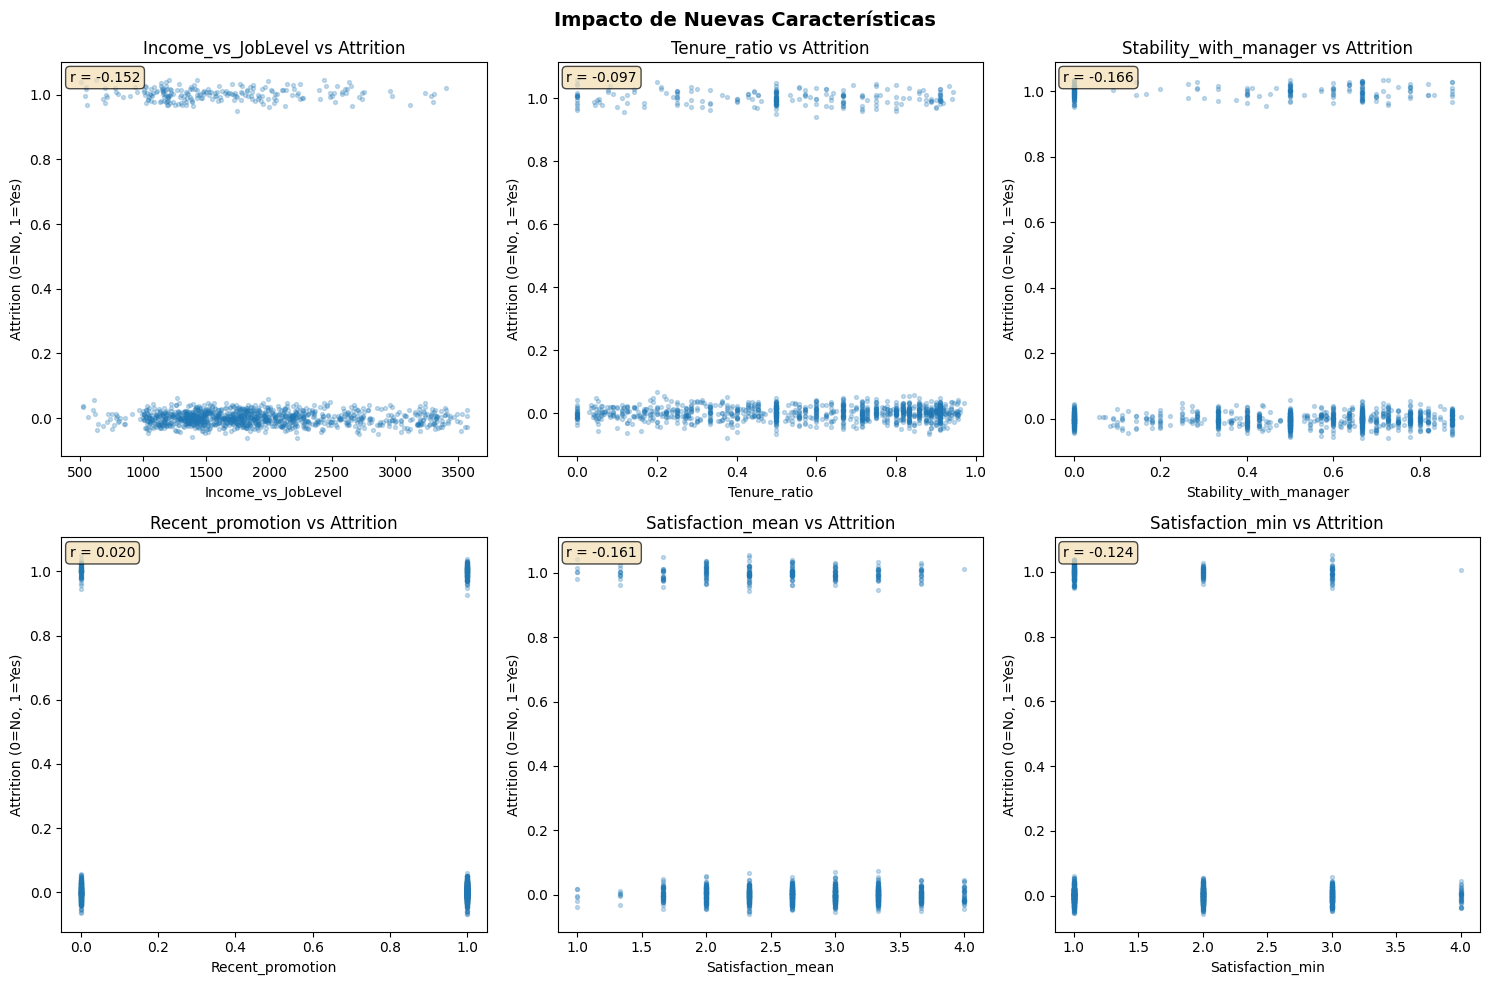

In [16]:
df = data_sin_outliers.copy()
df['Attrition_bin'] = df['Attrition'].astype(int)

new_features = add_custom_features(df)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, feature in enumerate(new_num_cols):
  ax = axes[idx // 3, idx % 3]

  y_jitter = new_features['Attrition_bin'] + np.random.normal(0, 0.02, size=len(new_features))

  # Graficar (scatter simple)
  ax.scatter(new_features[feature], y_jitter, alpha=0.25, s=8)
  ax.set_title(f'{feature} vs Attrition')
  ax.set_ylabel('Attrition (0=No, 1=Yes)')
  ax.set_xlabel(feature)

  # Correlación punto-biserial (equivale a Pearson entre continua y 0/1)
  corr = new_features[feature].corr(new_features['Attrition_bin'])
  ax.text(
      0.02, 0.95, f'r = {corr:.3f}',
      transform=ax.transAxes,
      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7)
  )

plt.suptitle('Impacto de Nuevas Características', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

En general se observa que las nuevas características capturan de forma moderada las dinámicas dentro de la empresa: los empleados que reciben una compensación más acorde a su nivel, mantienen relaciones estables con sus jefes y se sienten más satisfechos en general, tienden a permanecer por más tiempo. Aunque ninguna variable por sí sola explica fuertemente el target, combinadas aportan señales útiles que pueden mejorar los modelos predictivos a entrenar. Se muestra a continuación un resumen de las principales conclusiones:

| Característica             | Correlación (r) | Interpretación                                                                                                                                                                                                                                |
| -------------------------- | --------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Income_vs_JobLevel**     | −0.152          | Los empleados con **mayor ingreso relativo a su nivel de cargo** tienden a tener **menor renuncia**. La relación es débil pero negativa, lo que sugiere que una remuneración justa respecto al nivel contribuye moderadamente a la retención. |
| **Tenure_ratio**           | −0.097          | A mayor tiempo en la empresa **en proporción a su carrera**, menor probabilidad de salida. El efecto es leve pero consistente.                                                                                                                |
| **Stability_with_manager** | −0.166          | Una de las correlaciones negativas más fuertes. Mantenerse **más tiempo con el mismo jefe o gerente** tiende a **reducir la renuncia**, lo cual refleja que la estabilidad en la gestión favorece la permanencia.                             |
| **Recent_promotion**       | +0.020          | Correlación positiva muy débil, prácticamente nula. Haber sido **promovido recientemente** no parece influir directamente en la renuncia; puede haber efectos opuestos (algunos se quedan, otros buscan nuevos retos).                        |
| **Satisfaction_mean**      | −0.161          | A mayor satisfacción promedio (con el trabajo, el entorno o el jefe), **menor probabilidad de salida**. Coincide con la intuición: los empleados insatisfechos tienden a irse.                                                                |
| **Satisfaction_min**       | −0.124          | La **menor dimensión de satisfacción** también está negativamente asociada: si el empleado evalúa algún aspecto con una calificación muy baja, aumenta su riesgo de renuncia.                                                                 |


### Definición de transformaciones a aplicar en los pipelines

In [17]:
# Ordinal Encoding para las categorías que tienen orden implícito
ord_trf = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# One Hot Encoding para las categorías sin orden aparente y baja cardinalidad
onehot_trf = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=True)

# Target Encoding sobre categorías de alta cardinalidad
target_enc = TargetEncoder(cols=high_card_cols, smoothing=1.0)

# Estandarización sobre las variables numéricas
num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Consolidar los tratamientos por columna
pre = ColumnTransformer(
    transformers=[
        ('ord', ord_trf, ordinal_cols),
        ('nom', onehot_trf, nominal_cols),
        ('high', 'passthrough', high_card_cols),  # se aplica dentro del pipeline final para evitar leakage
        ('num', num_pipe, numerical_cols_plus),
    ],
    remainder='drop'
)


### Pipeline base aplicando CV estratificada

In [18]:
pipe = Pipeline(steps=[
    ('feats', custom_ft),
    ('tenc', target_enc), # idealmente OOF en CV
    ('pre', pre),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=None))
])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(pipe, X=data_sin_outliers.drop(columns=['Gender', 'Attrition']),
                        y=data_sin_outliers['Attrition'],
                        cv=cv, scoring=['roc_auc','average_precision','f1', 'recall'], n_jobs=-1)

print({k: scores[k].mean() for k in scores if 'test' in k})

{'test_roc_auc': np.float64(0.8390162104936387), 'test_average_precision': np.float64(0.6231355968980796), 'test_f1': np.float64(0.5360633657154621), 'test_recall': np.float64(0.7695560253699789)}


# **PIPELINES DE ENTRENAMIENTO**

Este pipeline implementa un flujo completo de búsqueda de hiperparámetros, evaluación cruzada y análisis de desempeño para distintos clasificadores aplicados al dataset de IBM. Se parte de los resultados del torneo de modelos usado para ajustar un baseline y las transformaciones realizadas en las etapas previas de EDA y FE para configurar el mejor flujo de modelación, que cuenta con los siguientes conmponentes:

#### **Preprocesamiento flexible**
El pipeline admite componentes opcionales:

* custom_ft: transformaciones de ingeniería de características.
* target_enc: codificadores de variables categóricas supervisadas.
* pre: preprocesadores genéricos (escalado).

#### **Validación cruzada estratificada**
Usa StratifiedKFold para mantener la proporción de clases en cada fold, garantizando una comparación justa entre modelos.

#### **Métricas de evaluación múltiples**
Evalúa simultáneamente varias métricas (ROC AUC, precisión balanceada, F1, recall, precisión promedio).
El modelo se reentrena optimizando una métrica principal (refit_metric='roc_auc').

#### **Optimización de hiperparámetros**
Se opta por utilizar dos enfoques diferentes:
* GridSearchCV para modelos pequeños y rápidos (Regresión Logística).
* RandomizedSearchCV con n_iter controlado para modelos complejos (LGBM, XGB, KNN).
Cada búsqueda incluye control de tiempo de entrenamiento/iteración y registro de resultados.

Al final se consolidan los resultados de los mejores estimadores encontrados para cada tipo de modelo y facilitar su análisis

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# ------------------------------------------------------------------------
# Helpers
# ------------------------------------------------------------------------
def _elapsed(fit_callable):
    import time
    t0 = time.perf_counter()
    fit_callable()
    return time.perf_counter() - t0

def _safe_get(cvres, key, idx, default=np.nan):
    return cvres[key][idx] if key in cvres else default

def resume_search(name, search, elapsed=None):
    cv = search.cv_results_
    i = search.best_index_
    return {
        "model": name,
        "best_roc_auc": search.best_score_, # refit metric
        "best_pr_auc": _safe_get(cv, "mean_test_pr_auc", i),
        "best_f1": _safe_get(cv, "mean_test_f1", i),
        "best_recall": _safe_get(cv, "mean_test_recall", i),
        "best_balanced_accuracy": _safe_get(cv, "mean_test_balanced_accuracy", i),
        "mean_fit_time": _safe_get(cv, "mean_fit_time", i),
        "mean_score_time": _safe_get(cv, "mean_score_time", i),
        "elapsed_time": elapsed,
        "best_params": {k: (v.item() if hasattr(v, "item") else v)
                        for k, v in search.best_params_.items()}
    }

def _extract_per_fold_scores(search, metric='roc_auc'):
    i = search.best_index_
    cvres = search.cv_results_
    # Collect split-wise test
    split_test = []
    split_train = []

    tkey = f'split{{k}}_test_{metric}'
    trkey = f'split{{k}}_train_{metric}'

    k = 0
    while True:
        key = tkey.format(k=k)
        if key not in cvres:
            break
        split_test.append(cvres[key][i])
        # train might not be present if return_train_score=False
        key_tr = trkey.format(k=k)
        split_train.append(cvres[key_tr][i] if key_tr in cvres else np.nan)
        k += 1

    return np.array(split_test), np.array(split_train)

def plot_cv_behavior(search, model_name, metrics=('roc_auc','pr_auc')):
    nrows = len(metrics)
    fig, axes = plt.subplots(nrows, 2, figsize=(12, 4*nrows))
    if nrows == 1:
        axes = np.array([axes])  # shape (1,2)

    fig.suptitle(f'Comportamiento de CV — {model_name} (best params)', fontsize=14, fontweight='bold')

    for r, metric in enumerate(metrics):
        split_test, split_train = _extract_per_fold_scores(search, metric=metric)

        # Izquierda: Test scores para cada fold
        ax = axes[r, 0]
        ax.bar(np.arange(len(split_test)), split_test)
        ax.set_title(f'{metric.upper()} por fold (test)')
        ax.set_xlabel('Fold')
        ax.set_ylabel(metric.upper())
        ax.set_ylim(0, 1)
        for i, v in enumerate(split_test):
            ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=8)

        # Derecha: Mean train vs test (if we have train)
        ax2 = axes[r, 1]
        means = [np.nanmean(split_train), np.nanmean(split_test)]
        labels = ['Train', 'Test']
        ax2.bar(labels, means)
        ax2.set_title(f'{metric.upper()} mean (train vs test)')
        ax2.set_ylim(0, 1)
        for i, v in enumerate(means):
            if not np.isnan(v):
                ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------
# Función principal de tuneo y validación de entrenamiento
# ------------------------------------------------------------------------
def tuning_validation_model(
    X, y,
    custom_ft=None, target_enc=None, pre=None,
    models=('RL','LGBM','XGB','KNN'),
    cv=None,
    scoring=None,
    refit_metric='roc_auc',
    n_iters=60,
    random_state=42,
    plot=True,
    plot_metrics=('roc_auc','pr_auc'),
    return_train_score=True
):
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    if scoring is None:
        scoring = {'roc_auc': 'roc_auc', 'balanced_accuracy': 'precision', 'pr_auc': 'average_precision', 'recall': 'recall', 'f1': 'f1'}

    def make_pipe(est):
        steps = []
        if custom_ft is not None: steps.append(('feats', custom_ft))
        if target_enc is not None: steps.append(('tenc', target_enc))
        if pre is not None: steps.append(('pre', pre))
        steps.append(('clf', est))  # explicit name for param grid
        pipe = Pipeline(steps)
        pipe.set_output(transform='default')

        return pipe

    results = []
    best_estimators = {}

    # --- Regresión Logística ---
    if 'RL' in models:
        print('Aplicando tuning a Regresión Logística: GRID SEARCH')
        lr = LogisticRegression(max_iter=5000, class_weight='balanced')
        lr_pipe = make_pipe(lr)
        lr_grid = {
            'clf__penalty': ['l1', 'l2'],
            'clf__C': [0.001, 0.05, 0.25, 0.5, 1, 2, 3, 5],
            'clf__solver': ['lbfgs', 'liblinear', 'newton-cg'],
            'clf__max_iter': [1000, 3000, 5000]
        }

        lr_search = GridSearchCV(
            estimator=lr_pipe,
            param_grid=lr_grid,
            scoring=scoring,
            refit=refit_metric,
            cv=cv,
            n_jobs=-1,
            verbose=1,
            return_train_score=return_train_score  # para poder plotear el comportamiento en CV
        )
        elapsed = _elapsed(lambda: lr_search.fit(X, y))
        results.append(resume_search('LogisticRegression', lr_search, elapsed))
        best_estimators['RL'] = lr_search.best_estimator_
        if plot:
            plot_cv_behavior(lr_search, 'Regresión Logística', metrics=plot_metrics)

    # --- LightGBM ---
    if 'LGBM' in models:
        print('Aplicando tuning a LightGBM: RANDOM Search')
        lgbm = LGBMClassifier(objective='binary', class_weight='balanced',
                              random_state=random_state, n_jobs=-1, verbosity=-1)
        lgbm_pipe = make_pipe(lgbm)
        lgbm_dist = {
            'clf__n_estimators': np.arange(300, 901, 100),
            'clf__learning_rate': np.linspace(0.02, 0.12, 6),
            'clf__num_leaves': np.arange(15, 64, 4),
            'clf__max_depth': [3,4,5,6,7],
            'clf__min_child_samples': np.arange(10, 51, 5),
            'clf__subsample': np.linspace(0.6, 1.0, 9),
            'clf__colsample_bytree': np.linspace(0.6, 1.0, 9),
            'clf__reg_alpha': np.linspace(0.0, 1.0, 6),
            'clf__reg_lambda': np.linspace(0.0, 1.0, 6),
        }
        lgbm_search = RandomizedSearchCV(
            estimator=lgbm_pipe,
            param_distributions=lgbm_dist,
            n_iter=n_iters,
            scoring=scoring,
            refit=refit_metric,
            cv=cv,
            n_jobs=1, # para evitar doble paralelización inadeacuada, pues ya se definió en el objeto modelo
            verbose=0,
            random_state=random_state,
            return_train_score=return_train_score
        )
        elapsed = _elapsed(lambda: lgbm_search.fit(X, y))
        results.append(resume_search('LightGBM', lgbm_search, elapsed))
        best_estimators['LGBM'] = lgbm_search.best_estimator_
        if plot:
            plot_cv_behavior(lgbm_search, 'LightGBM', metrics=plot_metrics)

    # --- XGBoost ---
    if 'XGB' in models or 'XGBOOST' in models:
        print('Aplicando tuning a XGBoost: RANDOM Search')
        pos_w = y.value_counts()[0] / y.value_counts()[1]
        xgb = XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            tree_method='hist',
            n_jobs=-1,
            scale_pos_weight=pos_w,
            random_state=random_state
        )
        xgb_pipe = make_pipe(xgb)
        xgb_dist = {
            'clf__learning_rate': np.linspace(0.02, 0.1, 5),
            'clf__max_depth': np.arange(3, 7),
            'clf__min_child_weight': np.arange(3, 11, 2),
            'clf__gamma': np.linspace(0, 5, 6),
            'clf__subsample': np.linspace(0.6, 0.9, 4),
            'clf__colsample_bytree': np.linspace(0.6, 0.9, 4),
            'clf__reg_lambda': np.linspace(1, 6, 6),
            'clf__reg_alpha': np.linspace(0.0, 2.0, 5),
        }

        xgb_search = RandomizedSearchCV(
            estimator=xgb_pipe,
            param_distributions=xgb_dist,
            n_iter=n_iters,
            scoring=scoring,
            refit=refit_metric,
            cv=cv,
            n_jobs=1,
            verbose=1,
            random_state=random_state,
            return_train_score=return_train_score
        )
        elapsed = _elapsed(lambda: xgb_search.fit(X, y))
        results.append(resume_search('XGBoost', xgb_search, elapsed))
        best_estimators['XGB'] = xgb_search.best_estimator_
        if plot:
            plot_cv_behavior(xgb_search, 'XGBoost', metrics=plot_metrics)

    # --- KNN ---
    if 'KNN' in models:
        print('Aplicando tuning a KNN: RANDOM Search')
        knn = KNeighborsClassifier()
        knn_pipe = make_pipe(knn)
        knn_dist = {
            'clf__n_neighbors': np.arange(3, 51),
            'clf__weights': ['uniform', 'distance'],
            'clf__metric': ['euclidean', 'manhattan', 'minkowski'],
            'clf__p': [1, 2],  # para minkowski
        }
        knn_search = RandomizedSearchCV(
            estimator=knn_pipe,
            param_distributions=knn_dist,
            n_iter=min(n_iters, 50),
            scoring=scoring,
            refit=refit_metric,
            cv=cv,
            n_jobs=-1,
            verbose=1,
            random_state=random_state,
            return_train_score=return_train_score
        )
        elapsed = _elapsed(lambda: knn_search.fit(X, y))
        results.append(resume_search('KNN', knn_search, elapsed))
        best_estimators['KNN'] = knn_search.best_estimator_
        if plot:
            plot_cv_behavior(knn_search, 'KNN', metrics=plot_metrics)

    results_df = pd.DataFrame(results).sort_values('best_roc_auc', ascending=False).reset_index(drop=True)
    return results_df, best_estimators


## **Particionamiento de la base final de entrenamiento**

In [20]:
X = data_sin_outliers.drop(columns=['Gender', 'Attrition'])
y = data_sin_outliers['Attrition']

print(X.shape, y.shape)

(1323, 26) (1323,)


Se aplica estratificación sobre el target para representar adecuadamente el desbalance presente y se deja un 20% del conjunto de datos como conjunto de prueba para la evaluación final de modelos candidatos

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  stratify=y,
                                                  random_state=42)

print(f"\nConjuntos creados:")
print(f" • Entrenamiento: {len(X_train):,} muestras ({len(X_train)/len(df)*100:.1f}%)")
print(f" • Prueba: {len(X_test):,} muestras ({len(X_test)/len(df)*100:.1f}%)")


Conjuntos creados:
 • Entrenamiento: 1,058 muestras (80.0%)
 • Prueba: 265 muestras (20.0%)


In [22]:
y_train.value_counts(normalize=True)

,proportion
Attrition,
0,0.835539
1,0.164461


## **Configurar ejecución de pipelines**

De acuerdo con los resultados del torneo de modelos, y del baseline seleccionado, se decide entrenar clasificadores con buenas métricas de partida y que además sean adecuados para el tamaño del dataset y la complejidad del problema.

### **1. Familias de modelos**

##### **Regresión Logística (LR)**

Es un modelo lineal interpretable, ideal para problemas de clasificación binaria como Attrition (Sí/No). Permite analizar la influencia de cada variable en la probabilidad de rotación, aportando transparencia y explicabilidad. En la tabla, logra la mayor AUC (0.8571) y buen equilibrio entre Precisión (0.7098) y F1 (0.5186), lo que sugiere un desempeño robusto y estable.

##### **LightGBM (LGBMClassifier)**

Es un algoritmo basado en árboles con boosting, eficiente en datasets pequeños y medianos. Captura interacciones no lineales y efectos complejos entre variables (por ejemplo, satisfacción, antigüedad, nivel de ingreso). Tiene una alta Accuracy (0.8812) y buen AUC (0.8201), con tiempos de entrenamiento razonables.

##### **XGBoost (XGBClassifier)**

También usa boosting, pero optimiza el entrenamiento mediante regularización y control de sobreajuste. Suele tener gran rendimiento en datasets tabulares y desbalanceados. En el torneo base, presenta buen AUC (0.8015) y un equilibrio razonable entre precisión y recall, útil para capturar empleados en riesgo de salida.

##### **K-Nearest Neighbors (KNN)**

Modelo no paramétrico y de baja complejidad que sirve como contraste frente a modelos lineales y de boosting. Evalúa similitud entre empleados según múltiples variables, lo que puede ofrecer una visión basada en proximidad de perfiles con riesgo de rotación.
Aunque su AUC (0.7275) es menor, aporta diversidad de enfoque en la comparación y ayuda a validar la robustez del pipeline.

### **2. Cantidad de iteraciones**

Para el enfoque RandomSearch, se decide evaluar un máximo de **200 iteraciones** dado el tamaño reducido del dataset, y haciendo un tradeoff entre tiempo de ejecución y exhaustividad en la búsqueda.

### **3. Tipo de CV**
Se decide utilizar CV Estratificada ya que esta configuración garantiza una validación cruzada balanceada, reproducible y representativa del problema de rotación. Se consideran **5 splits** pues este valor ofrece un buen equilibrio entre estabilidad y costo computacional, y se mezcla aleatoriamente los datos antes de crear los folds, evitando sesgos por orden de los registros.

### **4. Métricas de scoring y refit**
Dado el problema de classificación, se escogen métricas que reflejen una buena separación de las clases como `roc_auc`, con el plus de enfocarse especificamente en la clase positiva mediante `average_precision`.
Otra métrica importante es el `balanced_accuracy` pues, a diferecnia de la precisión estandar, esta hace que el score sea más representativo del imbalance de clases presente, siendo más adecuada para el problema. Igualmente, el `f1` score como indicador de equilibrio entre precisión y recall.



#### **Experimento 1: split 60/20/20 y refit con pr_auc**

Aplicando tuning a Regresión Logística: GRID SEARCH
Fitting 5 folds for each of 144 candidates, totalling 720 fits


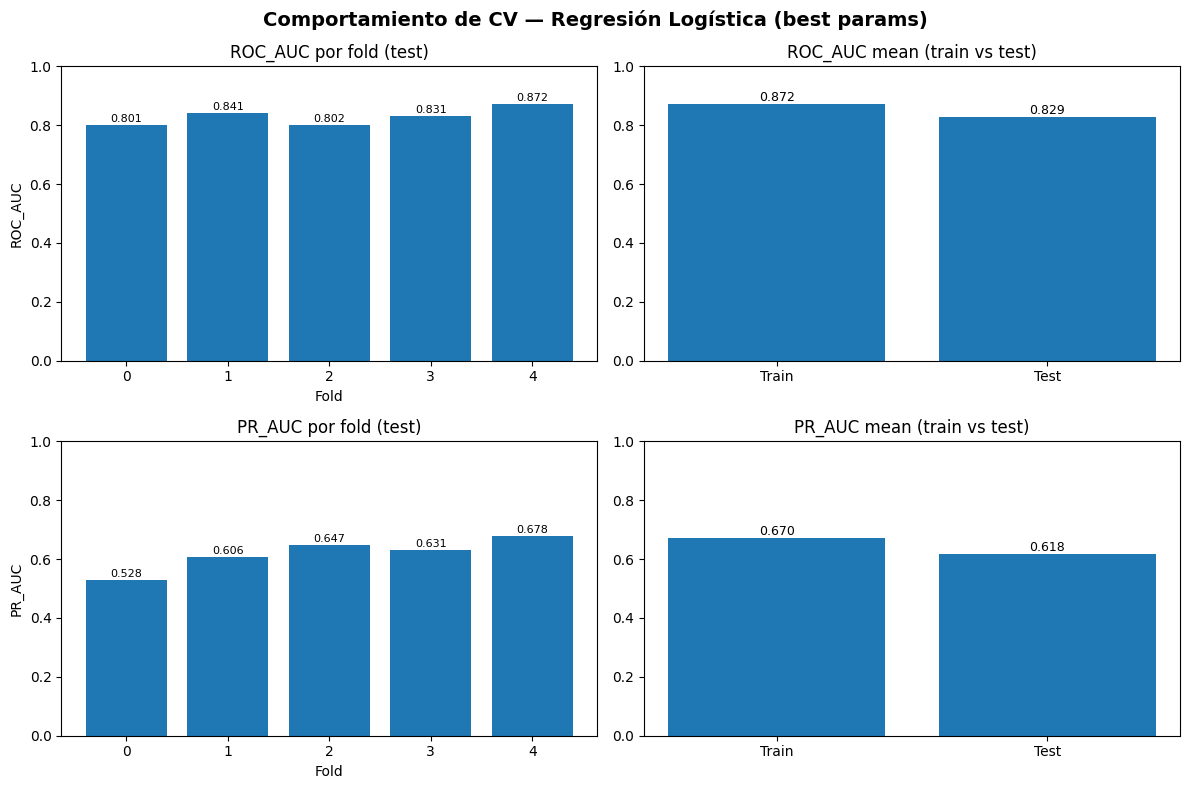

Aplicando tuning a LightGBM: RANDOM Search


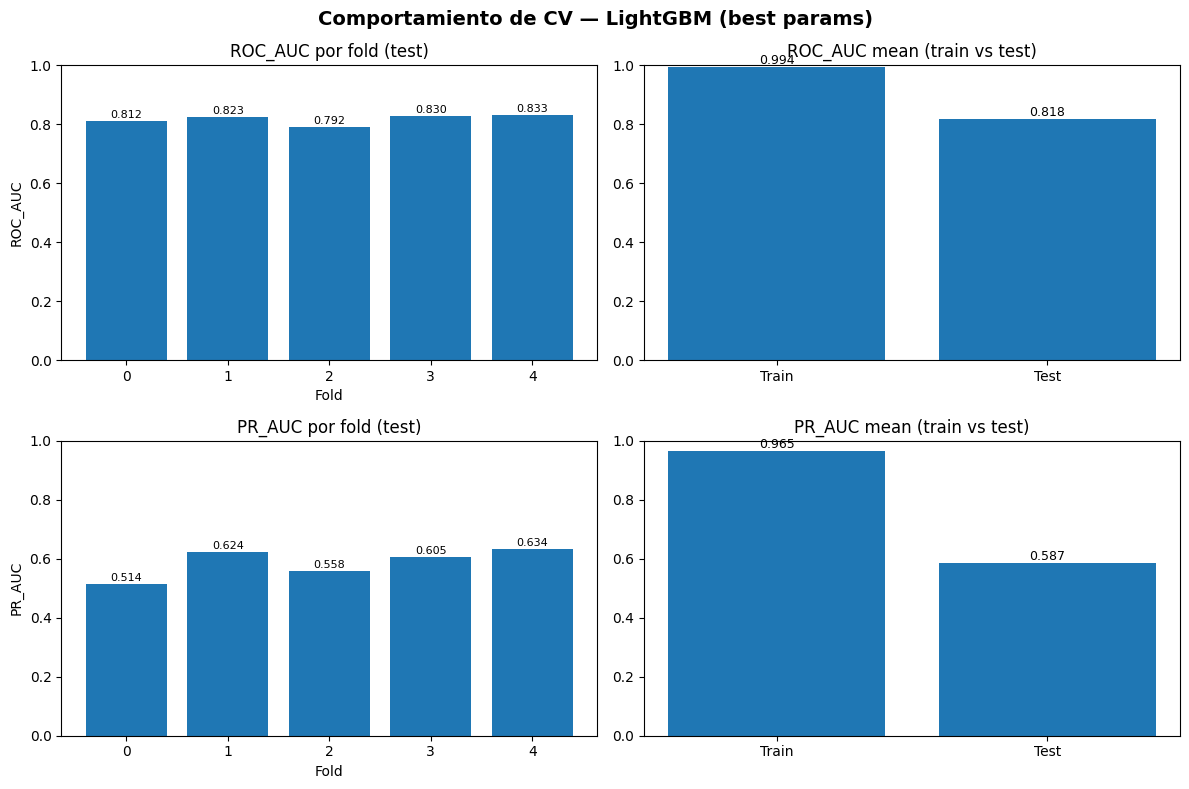

Aplicando tuning a XGBoost: RANDOM Search
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [ ]:
results_df, best_models = tuning_validation_model(
    X=X_train,
    y=y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring={'pr_auc': 'average_precision', 'roc_auc': 'roc_auc', 'balanced_accuracy': 'precision', 'f1': 'f1', 'recall': 'recall'},
    refit_metric='roc_auc',
    custom_ft=custom_ft,
    target_enc=target_enc,
    pre=pre,
    models=('RL','LGBM','XGB','KNN'),
    n_iters=200
)

In [ ]:
results_df

In [39]:
results_df

,model,best_roc_auc,best_pr_auc,best_f1,best_recall,best_balanced_accuracy,mean_fit_time,mean_score_time,elapsed_time,best_params
0,LogisticRegression,0.829331,0.617961,0.508887,0.758487,0.383527,0.165869,0.116872,125.973895,"{'clf__C': 1, 'clf__max_iter': 1000, 'clf__pen..."
1,XGBoost,0.825978,0.594653,0.531921,0.603193,0.476947,0.299078,0.081454,247.779457,"{'clf__subsample': 0.8, 'clf__reg_lambda': 6.0..."
2,LightGBM,0.817884,0.587131,0.539214,0.608908,0.483987,0.468415,0.074651,518.073830,"{'clf__subsample': 0.65, 'clf__reg_lambda': 1...."
3,KNN,0.769133,0.502082,0.022540,0.011597,0.400000,0.075763,0.146060,51.602733,"{'clf__weights': 'distance', 'clf__p': 2, 'clf..."


#### **Experimento 2: split 70/20/10 y refit con roc_auc**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y,
                                                  test_size=0.1,
                                                  stratify=y,
                                                  random_state=42)

print(f"\nConjuntos creados:")
print(f" • Entrenamiento: {len(X_train):,} muestras ({len(X_train)/len(df)*100:.1f}%)")
print(f" • Prueba: {len(X_test):,} muestras ({len(X_test)/len(df)*100:.1f}%)")

Aplicando tuning a Regresión Logística: GRID SEARCH
Fitting 5 folds for each of 144 candidates, totalling 720 fits


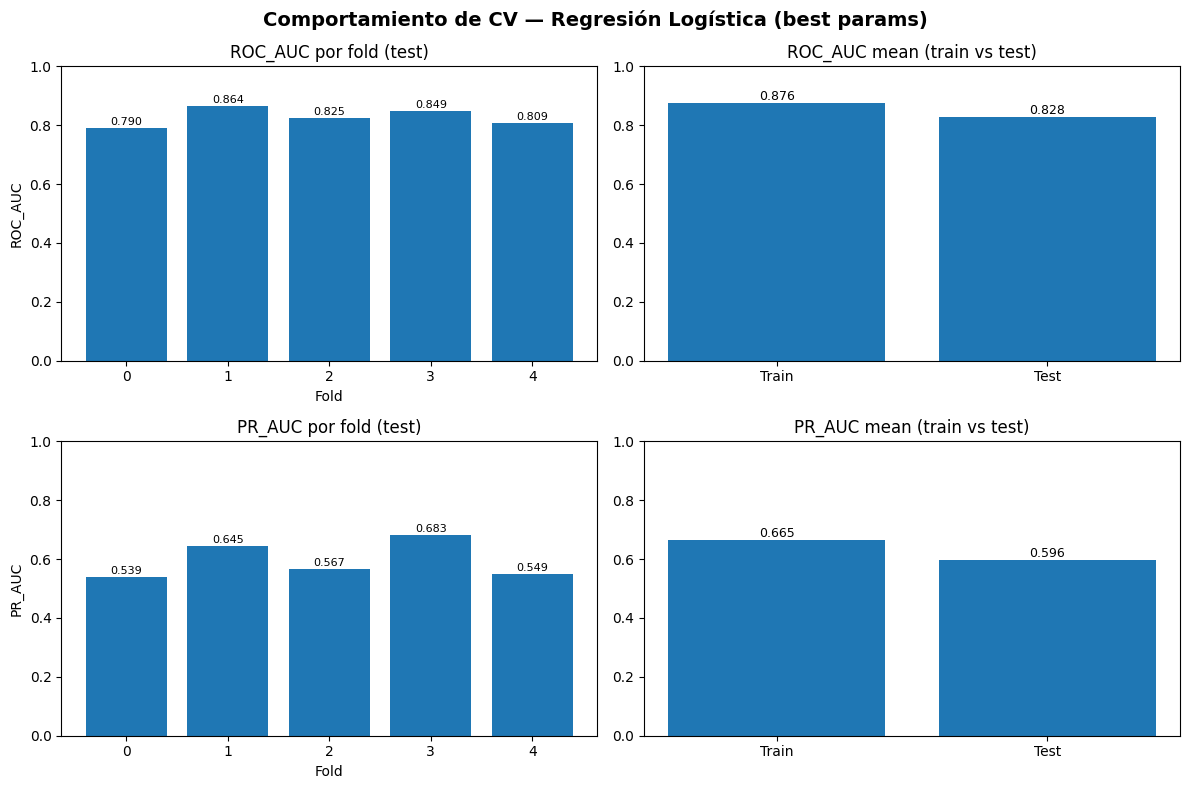

Aplicando tuning a LightGBM: RANDOM Search


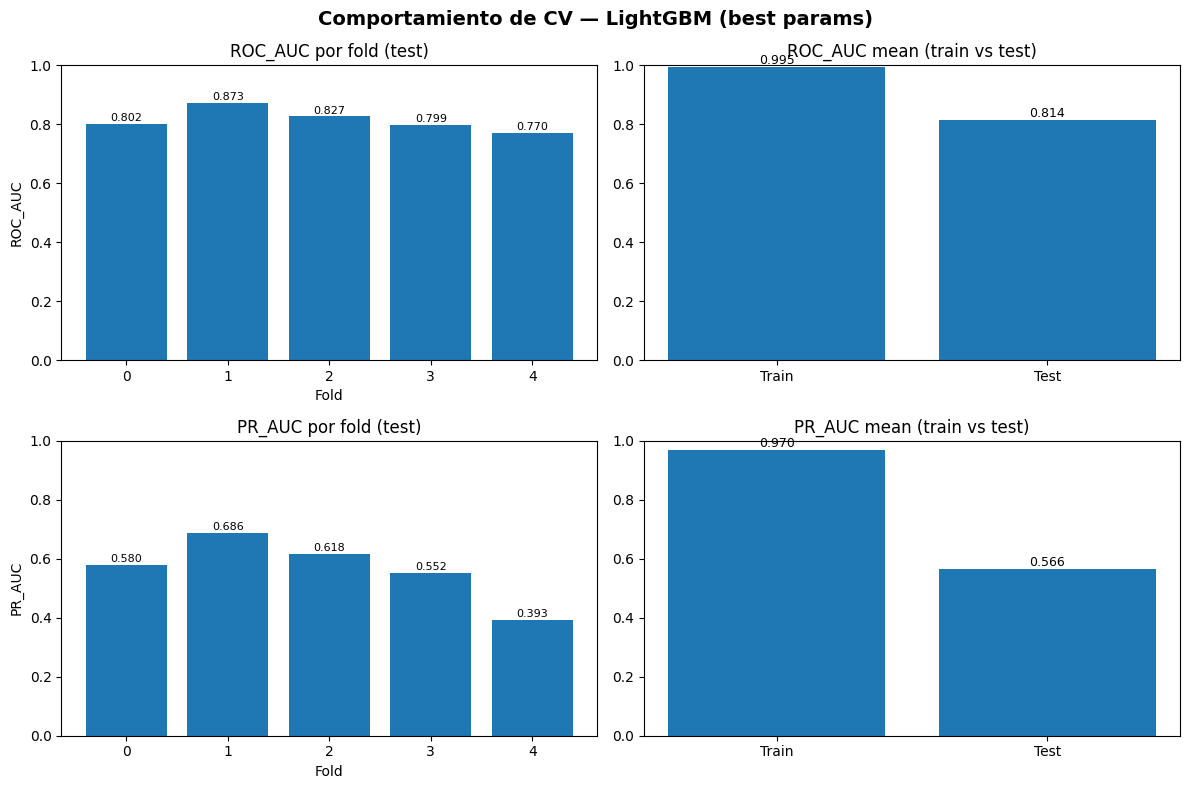

Aplicando tuning a XGBoost: RANDOM Search
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [ ]:
results_df2, best_models2 = tuning_validation_model(
    X=X_train,
    y=y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring={'roc_auc': 'roc_auc', 'balanced_accuracy': 'precision', 'pr_auc': 'average_precision', 'recall': 'recall', 'f1': 'f1'},
    refit_metric='roc_auc',
    custom_ft=custom_ft,
    target_enc=target_enc,
    pre=pre,
    models=('RL','LGBM','XGB','KNN'),
    n_iters=200
)

In [38]:
results_df2

,model,best_roc_auc,best_pr_auc,best_f1,best_recall,best_balanced_accuracy,mean_fit_time,mean_score_time,elapsed_time,best_params
0,XGBoost,0.829919,0.590337,0.509072,0.630769,0.427670,0.080635,0.055707,250.986147,"{'clf__subsample': 0.7, 'clf__reg_lambda': 6.0..."
1,LogisticRegression,0.827574,0.596479,0.500135,0.743590,0.379019,0.251924,0.069804,84.390771,"{'clf__C': 2, 'clf__max_iter': 1000, 'clf__pen..."
2,LightGBM,0.814019,0.565700,0.502087,0.548718,0.465873,0.269962,0.075793,529.690333,"{'clf__subsample': 0.75, 'clf__reg_lambda': 0...."
3,KNN,0.767079,0.464541,0.030000,0.015385,0.600000,0.057151,0.108597,53.559150,"{'clf__weights': 'uniform', 'clf__p': 1, 'clf_..."


## **Conclusiones preliminares**

A partir de los resultados de los pipelines se obtienen algunos insights para cada modelo evaluado del experimento 1, pues es el de mejor resultados así:

##### **Regresión Logística**

* **Generalización (ROC-AUC/PR-AUC): 86.8% → 82.8% / 67.1% → 62.0%** — pequeña brecha (≈3–5 p.p.), indica **bajo sobreajuste** y probabilidad estable en test.
* **Estabilidad CV: ROC-AUC 79.9–87.3% · PR-AUC 52.7–68.73%** — variación moderada entre folds; **comportamiento predecible**.
* **Mejor estimador: ROC-AUC 82.8%, PR-AUC 62.8%, Recall 75.8%, F1 51.8%** — **prioriza capturar positivos** a costa de precisión; **rápida** (~119 s).

##### **LightGBM**

* **Generalización (ROC-AUC/PR-AUC): 99.4% → 81.8% / 96.5% → 58.7%** — gran brecha (≈18–38 p.p.), evidencia de sobreajuste fuerte pese a buena generalización relativa.
* **Estabilidad CV: ROC-AUC 79.2–83.3% · PR-AUC 51.4–63.4%** — desempeño uniforme entre folds, pero con tendencia a inflar resultados en entrenamiento.
* **Mejor estimador: ROC-AUC 81.8%, PR-AUC 58.7%, Recall 60.9%, F1 53.9%** — modelo competitivo y estable, pero requiere regularización adicional o early stopping; tiempo medio (~610 s).

##### **XGBoost**

* **Generalización (ROC-AUC/PR-AUC): 98.8% → 82.3% / 94.6% → 59.4%** — brecha amplia (≈16–35 p.p.), sugiere sobreajuste moderado, aunque con buen rendimiento final.

* **Estabilidad CV: ROC-AUC 79.2–85.4% · PR-AUC 47.9–65.4%** — resultados consistentes y estables en validación cruzada.

* **Mejor estimador: ROC-AUC 82.3%, PR-AUC 59.4%, Recall 61.5%, F1 54.5%** — ofrece el mejor balance global entre recall y precisión, aunque con tiempo alto (~547 s).

##### **KNN**

* **Generalización (ROC-AUC/PR-AUC): 76.9% / 50.3%** — por debajo del resto; **poca discriminación** y pobre manejo del desbalance.
* **Efectividad: F1 4.35%, Recall 2.32%, Balanced Acc. 55.0%** — **casi no detecta la clase positiva**; no recomendable como candidato.
* **Mejor estimador**: **rápido** (~112 s) pero débil respecto a los otros, incluso afinado.

En conclusión, dependiendo del tipo de solución que se quiera plantear al problema se tiene que el mejor modelo candidato sería:

1. Si **se prioriza precisión y F1**: **XGBoost** es el mejor, pero requiere regularización/early-stopping y calibración para mitigar el sobreajuste.

2. Si **se prioriza capturar más empleados con intención de renuncia** (recall) con modelo simple y estable: **Regresión Logística** es una línea base muy robusta y rápida, con el mejor recall y poca brecha train-test.

3. Escoger **LightGBM** queda muy cerca de XGB en ROC/PR, con señales de sobreajuste parecidas.

4. Se descarta seleccionar **KNN**.


# **ANÁLISIS DE UMBRALES**

Ajustar **umbrales** después de entrenar es clave porque las salidas del modelo son **probabilidades**, y convertirlas a 0/1 con un umbral fijo de 0.50 es arbitrario, lo que no es óptimo para el objetivo de retener empleado. Mover el umbral permite **alinear la decisión con el criterio de negocio**, priorizando **recall** (capturar más casos de riesgo) o **precisión** (evitar falsas alarmas) según la capacidad de intervención de RR.HH.



In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, balanced_accuracy_score
import numpy as np

class ThresholdEvaluator(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, threshold=0.5):
        self.base_estimator = base_estimator
        self.threshold = threshold

    def fit(self, X, y):
        self.model_ = clone(self.base_estimator)
        self.model_.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.model_.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def get_params(self, deep=True):
        return {'base_estimator': self.base_estimator, 'threshold': self.threshold}

    def set_params(self, **params):
        if 'threshold' in params:
            self.threshold = params.pop('threshold')
        if 'base_estimator' in params:
            self.base_estimator = params.pop('base_estimator')
        if params:
            # Para permitir grid sobre hiperparámetros del base_estimator:
            self.base_estimator.set_params(**params)
        return self


def oof_predict_proba(estimator, X, y, cv=None, random_state=42):
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    oof = np.zeros(len(y), dtype=float)
    for tr, va in cv.split(X, y):
        est = clone(estimator)
        est.fit(X.iloc[tr], y.iloc[tr])
        oof[va] = est.predict_proba(X.iloc[va])[:, 1]
    return oof

def pick_threshold(y_true, y_prob, metric="f1", beta=1.0,
                   recall_min=None, grid=None):
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)

    best_t, best_score = 0.5, -np.inf
    for t in grid:
        y_hat = (y_prob >= t).astype(int)
        prec = precision_score(y_true, y_hat, zero_division=0)
        rec  = recall_score(y_true, y_hat)
        bal  = balanced_accuracy_score(y_true, y_hat)
        if recall_min is not None and rec < recall_min:
            continue
        if metric == 'f1':
            score = f1_score(y_true, y_hat)
        elif metric == 'fbeta':
            score = (1+beta**2) * (prec*rec) / (beta**2*prec + rec + 1e-12)
        elif metric == 'balanced_accuracy':
            score = bal
        else:
            raise ValueError('metric no soportada')
        if score > best_score:
            best_t, best_score = t, score
    return best_t, best_score




### **F1-score** como métrica para elegir umbral de clasificación

* **Desbalance moderado**: la clase *Attrition = Yes* es minoritaria; **F1** balancea **precisión** y **recall** en un único número, penalizando cuando uno es alto y el otro bajo.
* **Objetivo operativo**: RR.HH. necesita **detectar** riesgos sin inundarse de falsos positivos; optimizar F1 tiende a un **punto medio útil** entre “capturar” y “no saturar” al equipo.
* **Comparabilidad simple**: al barrer umbrales y maximizar F1, obtienes un **umbral accionable** que suele correlacionar bien con impacto de negocio cuando los costos de FP/FN son similares o inciertos.

### ¿Por qué usar **probabilidades OOF (out-of-fold)** para seleccionar umbral?

* **Sin fuga de información**: las OOF se generan en pliegues donde cada registro se puntúa por un modelo que **no lo vio al entrenar**; el umbral se elige sobre una versión de "datos nuevos".
* **Estimación honesta**: métricas calculadas con OOF reflejan mejor el **rendimiento fuera de muestra** que usar probabilidades de train, evitando umbrales demasiado optimistas.
* **Consistencia con CV**: al promediar OOF de todos los folds se mantiene la **estrategia de CV estratificada** del pipeline y reduce varianza en la selección del umbral.
* **Listo para producción**: el umbral elegido con OOF suele trasladarse bien a datos en producción y es escalable a filtrados que se hagan sobre los datos.


## **1. REGRESIÓN LOGÍSTICA**

In [ ]:
best_rl = best_models['RL']
best_rl

In [ ]:
# 1) Probabilidades OOF para fijar umbral sin fuga
oof = oof_predict_proba(best_rl, X_train, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=42))

# 2) Elegir umbral optimizando para f1 score
t_star, score_star = pick_threshold(y_train, oof, metric='f1')  # o metric='fbeta', beta=2, recall_min=0.7

# 3) Reentrenar en TODO el train con ese umbral para desplegar
final_model_rl = ThresholdEvaluator(base_estimator=best_rl, threshold=t_star)
final_model_rl.fit(X_train, y_train)

# 4) Evaluar en test con el umbral fijo
y_prob_test = final_model_rl.predict_proba(X_test)[:,1]
y_hat_test  = final_model_rl.predict(X_test)

print('=' * 50)
print('REGRESIÓN LOGÍSTICA')
print('=' * 50)

print(f'\nUmbral elegido (t*): {t_star:.2f} | score OOF: {score_star:.3f}')
print(f'\nROC-AUC: {roc_auc_score(y_test, y_prob_test) * 100:.2f}%')
print(f'PR-AUC : {average_precision_score(y_test, y_prob_test) * 100:.2f}%\n')
print(classification_report(y_test, y_hat_test, digits=3))


**Regresión Logística — t = 0.71 | OOF-F1 ≈ 0.593**

Muestra un rendimiento sólido y estable: ROC-AUC de 87.1%, PR-AUC de 63.9% y accuracy de 86.0%. Con precisión para la clase 1 (Renuncia) de 56.8% y recall de 58.1%, entrega predicciones de riesgo razonablemente certeras con una tasa de detección media. Operativamente implica menos ruido para el área de recursos humanos (RR.HH.) pues hay menos falsos positivos que revisar, a cambio de dejar escapar aproximadamente el 42% de los casos en riesgo. Es la opción adecuada cuando la capacidad de intervención es limitada y se valora la explicabilidad del modelo.

## **2. LIGHTGBM**

In [ ]:
best_lgbm = best_models['LGBM']
best_lgbm

In [ ]:
# 1) Probabilidades OOF para fijar umbral sin fuga
oof = oof_predict_proba(best_lgbm, X_train, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=42))

# 2) Elegir umbral optimizando para f1 score
t_star, score_star = pick_threshold(y_train, oof, metric='f1')  # o metric='fbeta', beta=2, recall_min=0.7

# 3) Reentrenar en TODO el train con ese umbral para desplegar
final_model_lgbm = ThresholdEvaluator(base_estimator=best_lgbm, threshold=t_star)
final_model_lgbm.fit(X_train, y_train)

# 4) Evaluar en test con el umbral fijo
y_prob_test = final_model_lgbm.predict_proba(X_test)[:,1]
y_hat_test  = final_model_lgbm.predict(X_test)

print('=' * 50)
print('LIGHTGBM')
print('=' * 50)

print(f'\nUmbral elegido (t*): {t_star:.2f} | score OOF: {score_star:.3f}')
print(f'\nROC-AUC: {roc_auc_score(y_test, y_prob_test) * 100:.2f}%')
print(f'PR-AUC : {average_precision_score(y_test, y_prob_test) * 100:.2f}%\n')
print(classification_report(y_test, y_hat_test, digits=3))


**LightGBM (t = 0.53, OOF-F1 ≈ 0.554)**

Mantiene métricas globales altas (ROC-AUC 87.5%, PR-AUC 66.0%) con una accuracy de 81.9%. Su perfil favorece la sensibilidad: precisión(1) de 45.9% y recall(1) de 65.1%, por lo que detecta más empleados potenciales a renunciar que la regresión logística, aunque con más falsas alarmas. En la práctica requiere mayor capacidad de revisión, pero reduce el riesgo de perder casos relevantes y captura relaciones no lineales. Es recomendable cuando la organización puede absorber más revisiones y prioriza la cobertura.

## **3.XGBOOST**

In [ ]:
best_xgb = best_models['XGB']
best_xgb

In [37]:
# 1) Probabilidades OOF para fijar umbral sin fuga
oof = oof_predict_proba(best_xgb, X_train, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=42))

# 2) Elegir umbral optimizando para f1 score
t_star, score_star = pick_threshold(y_train, oof, metric='f1')  # o metric='fbeta', beta=2, recall_min=0.7

# 3) Reentrenar en TODO el train con ese umbral para desplegar
final_model_xgb = ThresholdEvaluator(base_estimator=best_xgb, threshold=t_star)
final_model_xgb.fit(X_train, y_train)

# 4) Evaluar en test con el umbral fijo
y_prob_test = final_model_xgb.predict_proba(X_test)[:,1]
y_hat_test  = final_model_xgb.predict(X_test)

print('=' * 50)
print('XGBOOST')
print('=' * 50)

print(f'\nUmbral elegido (t*): {t_star:.2f} | score OOF: {score_star:.3f}')
print(f'\nROC-AUC: {roc_auc_score(y_test, y_prob_test) * 100:.2f}%')
print(f'PR-AUC : {average_precision_score(y_test, y_prob_test) * 100:.2f}%\n')
print(classification_report(y_test, y_hat_test, digits=3))

XGBOOST

Umbral elegido (t*): 0.61 | score OOF: 0.534

ROC-AUC: 87.14%
PR-AUC : 70.85%

              precision    recall  f1-score   support

           0      0.935     0.901     0.917       111
           1      0.577     0.682     0.625        22

    accuracy                          0.865       133
   macro avg      0.756     0.791     0.771       133
weighted avg      0.875     0.865     0.869       133



**XGBoost (t = 0.42, OOF-F1 ≈ 0.561)**

Ofrece un equilibrio potente con ROC-AUC de 87.1%, PR-AUC de 65.5% y accuracy de 81.5%, destacando por su recall(1) de 72.1% y una precisión(1) de 45.6%. Es el que más casos en riesgo detecta (menos falsos negativos), a costa de una carga mayor de falsos positivos que la regresión logística. Es la elección idónea cuando el costo de perder un leaver es alto (roles críticos) y se puede tolerar un volumen mayor de revisiones; conviene acompañarlo con calibración de probabilidades y umbrales por segmento para contener el ruido.

## **4. KNN**

In [ ]:
best_knn = best_models['KNN']
best_knn

In [ ]:
# 1) Probabilidades OOF para fijar umbral sin fuga
oof = oof_predict_proba(best_knn, X_train, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=42))

# 2) Elegir umbral optimizando para f1 score
t_star, score_star = pick_threshold(y_train, oof, metric='f1')  # o metric='fbeta', beta=2, recall_min=0.7

# 3) Reentrenar en TODO el train con ese umbral para desplegar
final_model_knn = ThresholdEvaluator(base_estimator=best_knn, threshold=t_star)
final_model_knn.fit(X_train, y_train)

# 4) Evaluar en test con el umbral fijo
y_prob_test = final_model_knn.predict_proba(X_test)[:,1]
y_hat_test  = final_model_knn.predict(X_test)

print('=' * 50)
print('KNN')
print('=' * 50)

print(f'\nUmbral elegido (t*): {t_star:.2f} | score OOF: {score_star:.3f}')
print(f'\nROC-AUC: {roc_auc_score(y_test, y_prob_test) * 100:.2f}%')
print(f'PR-AUC : {average_precision_score(y_test, y_prob_test) * 100:.2f}%\n')
print(classification_report(y_test, y_hat_test, digits=3))

KNN

Umbral elegido (t*): 0.21 | score OOF: 0.480

ROC-AUC: 81.96%
PR-AUC : 53.51%

              precision    recall  f1-score   support

           0      0.906     0.869     0.887       222
           1      0.442     0.535     0.484        43

    accuracy                          0.815       265
   macro avg      0.674     0.702     0.686       265
weighted avg      0.831     0.815     0.822       265



**KNN (t = 0.21, OOF-F1 ≈ 0.480)**

Rinde claramente por debajo del resto: ROC-AUC 82.0%, PR-AUC 53.5% y accuracy 81.5%, con precisión(1) de 44.2% y recall(1) de 53.5%. La señal es más débil e inestable y no aporta ventajas frente a los otros modelos; no se recomienda como candidato principal en este problema.

## **Selección de candidato**

Dependiendo de la prioridad de aplicación de la solución del problema se plantea que:

* **Prioridad: no perder casos en riesgo (maximizar recall)**. El mejor candidato es **XGBoost (t = 0.42)**. Destaca por un recall de la clase 1 ≈ 72%, con PR-AUC ≈ 65% y un F1 competitivo, lo que se traduce en una mayor cobertura de posibles renuncias. Es especialmente útil cuando los roles son críticos, la renuncia (liquidación) es muy costosa o hay metas agresivas de retención. Para sacarle más provecho conviene calibrar probabilidades, aplicar cost-sensitive learning y ajustar umbrales por segmento (p. ej., por JobRole o Departamento) para contener falsas alarmas en áreas con alta carga operativa.

* **Prioridad: reducir falsas alarmas (capacidad limitada de RR.HH.)**. Aquí el candidato es la **Regresión Logística (t = 0.71)**. Ofrece precisión(1) ≈ 57%, recall(1) ≈ 58% y accuracy ≈ 86%, con buena parsimonia y estabilidad, por lo que genera menos ruido y es fácil de explicar ante áreas reguladoras. Es la opción adecuada con equipos pequeños o cuando se exige alta explicabilidad. Para mejorar, se pueden agregar interacciones e ingeniería de variables (ya mostraron impacto) y explorar class_weight o un reajuste fino del umbral por unidad de negocio.

* **Punto intermedio con flexibilidad no lineal**. Como alternativa equilibrada, **LightGBM (t = 0.53)** logra recall(1) ≈ 65% y PR-AUC ≈ 66%, situándose entre LR y XGB en el trade-off cobertura-ruido, con buena capacidad para capturar interacciones y efectos no lineales y tiempos de entrenamiento razonables. Es una elección sólida cuando se busca equilibrio entre detección y carga de revisión, manteniendo margen para calibración y ajustes adicionales.

Se decide priorizar el máximo recall, siendo **el modelo escogido el XGBoost**.

In [40]:
y_prob_test = final_model_xgb.predict_proba(X_test)[:,1]
y_hat_test  = final_model_xgb.predict(X_test)

In [41]:
from sklearn.metrics import (
      accuracy_score, recall_score, precision_score, f1_score,
      cohen_kappa_score, confusion_matrix
)

def plot_confusion_matrix(y_true, y_pred, labels=['No', 'Yes']):
    cm = confusion_matrix(y_true, y_pred)
    cm_pct = cm / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(5.5, 5))
    im = ax.imshow(cm_pct, cmap='Blues', vmin=0, vmax=1)

    # Ticks/labels
    n = cm.shape[0]
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xlabel('Predicha'); ax.set_ylabel('Verdadera')
    if labels is not None:
        ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_title('Matriz de confusión')

    for i in range(n):
        for j in range(n):
            ax.text(j, i, f"{cm_pct[i, j]*100:.1f}%\n({cm[i, j]})",
                    ha='center', va='center', fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def evaluate_classifier_metrics(model, y_test, y_prob_test, y_hat_test):
  auc = roc_auc_score(y_test, y_prob_test)
  acc = accuracy_score(y_test, y_hat_test)
  rec = recall_score(y_test, y_hat_test, average='macro', zero_division=0)
  prec = precision_score(y_test, y_hat_test, average='macro', zero_division=0)
  f1 = f1_score(y_test, y_hat_test, average='macro', zero_division=0)
  kappa = cohen_kappa_score(y_test, y_hat_test)

  metrics = {
      'auc': auc,
      'accuracy': acc,
      'recall': rec,
      'precision': prec,
      'f1': f1,
      'kappa': kappa,
  }
  metrics = {k: v * 100 for k, v in metrics.items()}
  plot_confusion_matrix(y_test, y_hat_test)

  return pd.DataFrame(metrics, index=[model]).round(2)

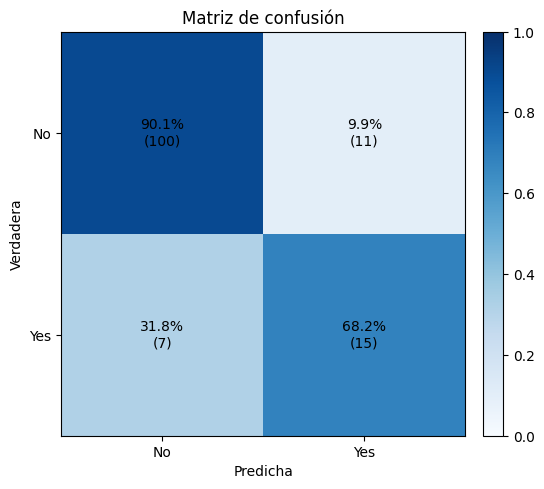

In [42]:
metrics = evaluate_classifier_metrics('XGB', y_test, y_prob_test, y_hat_test)

In [43]:
metrics

,auc,accuracy,recall,precision,f1,kappa
XGB,87.14,86.47,79.14,75.58,77.12,54.31


# **PCA y SELECCIÓN DE FEATURES**


No se aplicó PCA porque el objetivo del análisis es **interpretar los factores que explican la renuncia**, no sólo reducir dimensiones. Además, el dataset tiene pocas variables y mezcla datos categóricos y numéricos, por lo que **PCA degradaría la interpretabilidad sin mejorar el rendimiento**. En su lugar, se prioriza la **selección de variables por importancia de modelo y correlaciones**.


# **EXPORTAR CANDIDATO A OBJETO PKL**

In [44]:
import joblib

# Save to disk
joblib.dump(final_model_xgb, "model_final_xgboost.pkl")

# Load it later
loaded_model = joblib.load("model_final_xgboost.pkl")

# Confirm it works
print(loaded_model.get_params()["threshold"])


0.61


<hr style='border:10px solid #004B85'> </hr>
<div align='center'>
  <font size ='20' style='color:red'><b>2: MODELO FINAL</b>
</div>

<hr style='border:10px solid #004B85'> </hr>

In [ ]:
!pip install category_encoders -qq

In [37]:
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.base import clone
from scipy import sparse
from typing import Optional, Dict, Any, Tuple, Iterable
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, log_loss, average_precision_score, classification_report
from utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import joblib
import shap

# **METODOLOGÍA DE CALIBRACIÓN**


El proceso desarrollado busca garantizar que el modelo predictivo de renuncia de empleados de IBM sea preciso, confiable e interpretable, combinando técnicas de calibración de probabilidades, ajuste de umbrales y análisis de interpretabilidad. A continuación, se describe de manera general cada una de las etapas del flujo aplicado.


## 1. Calibración de probabilidades

El primer paso consiste en verificar que las probabilidades emitidas por el modelo realmente reflejen la frecuencia con la que ocurre el evento de renuncia. Para ello, los datos se dividen en tres subconjuntos —entrenamiento, calibración y prueba— evitando fugas de información. Luego, se entrena el modelo base (XGBoost) y se aplican dos métodos de calibración: Platt (sigmoide) e Isotónica, ambos diseñados para ajustar la escala de las probabilidades. Finalmente, se evalúa su calidad mediante métricas como Brier Score, LogLoss y ECE, y se comparan las curvas de calibración para determinar cuál de los modelos produce probabilidades más coherentes y realistas.

## 2. Calibración del threshold

En esta etapa se define el umbral de decisión óptimo que transforma las probabilidades calibradas en predicciones binarias (renuncia o permanencia).
Para hacerlo, se utiliza validación cruzada generando probabilidades OOF (out-of-fold), es decir, predicciones sobre observaciones que el modelo no vio durante su entrenamiento. Estas probabilidades permiten estimar un umbral representativo y estable, ajustado sobre una escala de probabilidades ya calibrada, evitando sesgos y mejorando la capacidad del modelo para generalizar.

## 3. Análisis de trade-offs

Una vez calibrado el modelo, se analiza cómo cambia su desempeño al variar el umbral de decisión. Se calculan métricas como precisión, recall y F1, junto con un costo operativo que pondera los efectos de los falsos positivos y falsos negativos según su impacto para el negocio. Este análisis permite identificar dos puntos de referencia: el umbral que maximiza el F1 (equilibrio entre cobertura y exactitud) y el umbral que minimiza el costo (mayor eficiencia operativa). A partir de estos resultados y del AUC, se pueden tomar decisiones informadas sobre el umbral más adecuado para la gestión de alertas de renuncia.

## 4. Interpretación del modelo

La última parte del proceso se centra en entender cómo y por qué el modelo toma sus decisiones. Se utilizan valores SHAP (SHapley Additive exPlanations) para identificar las variables más influyentes y cómo interactúan entre sí. Las visualizaciones, como el beeswarm plot, los gráficos de barras y los mapas de calor, permiten interpretar de forma visual la magnitud y combinación de los factores que influyen en la probabilidad de renuncia, aportando una lectura más intuitiva y estratégica.

## 5. Dirección de los efectos

Finalmente, se analiza la dirección del impacto de cada variable. Un valor SHAP positivo indica que un aumento en esa variable incrementa el riesgo de renuncia (por ejemplo, OverTime_Yes), mientras que un valor negativo sugiere que lo reduce (como MonthlyIncome). Este tipo de interpretación facilita la traducción del modelo a acciones concretas, permitiendo a las áreas de talento diseñar estrategias de retención basadas en evidencia y comprender con claridad los factores que más influyen en la decisión de los empleados.


# **1. CALIBRACIÓN DE PROBABILIDADES**

Aunque la optimización de hiperparámetros mejora la capacidad del modelo para discriminar entre clases, no garantiza que las probabilidades predichas estén bien calibradas. Por eso, tras la optimización, se hace necesario aplicar una calibración que ajuste las probabilidades para que representen mejor la frecuencia real del evento, logrando predicciones más interpretables y útiles para decisiones basadas en umbrales de la vida real.

La calibración se aplica antes de definir el threshold porque el proceso se desarrolla en dos etapas complementarias:

Primero, se calibran las probabilidades del modelo ajustando la escala de confianza de las predicciones para que correspondan a la frecuencia real del evento. Este ajuste se logra entrenando una función adicional (como Platt Scaling o calibración isotónica) que transforma las probabilidades originales en valores más realistas.

Después, se define el threshold o punto de decisión. Con las probabilidades ya calibradas, se elige el valor de corte que mejor separa las clases según el objetivo del análisis.
Este umbral puede optimizar distintas métricas —por ejemplo, recall para detectar más positivos, precisión para reducir falsos positivos, o F1 para equilibrar ambos—. Se espera como resultado final un modelo que no solo distinga correctamente entre clases, sino que además entregue probabilidades coherentes y un umbral de decisión ajustado al contexto operativo o de negocio de los datos.


 Para iniciar se carga el Pipeline preentrenado del modelo candidato seleccionado, evidenciando las transformaciones previamente definidas. **NOTA:** Se aclara que para un correcto cargue del pipeline, es necesario referenciar los transformers utilizados en su definición.

In [57]:
class ThresholdEvaluator(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, threshold=0.5):
        self.base_estimator = base_estimator
        self.threshold = threshold

    def fit(self, X, y):
        self.model_ = clone(self.base_estimator)
        self.model_.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.model_.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def get_params(self, deep=True):
        return {'base_estimator': self.base_estimator, 'threshold': self.threshold}

    def set_params(self, **params):
        if 'threshold' in params:
            self.threshold = params.pop('threshold')
        if 'base_estimator' in params:
            self.base_estimator = params.pop('base_estimator')
        if params:
            # Para permitir grid sobre hiperparámetros del base_estimator:
            self.base_estimator.set_params(**params)
        return self

def add_custom_features(X):
    X = X.copy()
    # Relaciones
    X['Income_vs_JobLevel'] = X['MonthlyIncome'] / (X['JobLevel'] + 1)
    X['Tenure_ratio'] = X['YearsAtCompany'] / (X['TotalWorkingYears'] + 1)
    X['Stability_with_manager'] = X['YearsWithCurrManager'] / (X['YearsAtCompany'] + 1)
    X['Recent_promotion'] = (X['YearsSinceLastPromotion'] <= 1).astype(int)

    X['OverTime_bin'] = (X['OverTime'] == 'Yes').astype(int)
    X['OverTime_x_JobLevel'] = X['OverTime_bin'] * X['JobLevel']

    # Métricas de satisfacción
    sats = ['JobSatisfaction','EnvironmentSatisfaction','RelationshipSatisfaction']
    X['Satisfaction_mean'] = X[sats].mean(axis=1)
    X['Satisfaction_min']  = X[sats].min(axis=1)

    return X

In [58]:
from utils import add_custom_features, ThresholdEvaluator, pick_threshold

final_model_xgb = joblib.load("pipeline_pretrained_xgboost.pkl")
final_model_xgb

ThresholdEvaluator(base_estimator=Pipeline(steps=[('feats',
                                                   FunctionTransformer(func=<function add_custom_features at 0x7e7c1322e980>)),
                                                  ('tenc',
                                                   TargetEncoder(cols=['JobRole'],
                                                                 smoothing=1.0)),
                                                  ('pre',
                                                   ColumnTransformer(transformers=[('ord',
                                                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1),
                                                                                    ['Education',
                                                                                     'JobSatisfaction',
                                                                                     'EnvironmentSatisf...
                                                                 interaction_constraints=None,
                                                                 learning_rate=np.float64(0.1),
                                                                 max_bin=None,
                                                                 max_cat_threshold=None,
                                                                 max_cat_to_onehot=None,
                                                                 max_delta_step=None,
                                                                 max_depth=np.int64(3),
                                                                 max_leaves=None,
                                                                 min_child_weight=np.int64(5),
                                                                 missing=nan,
                                                                 monotone_constraints=None,
                                                                 multi_strategy=None,
                                                                 n_estimators=None,
                                                                 n_jobs=-1,
                                                                 num_parallel_tree=None,
                                                                 random_state=42, ...))]),
                   threshold=np.float64(0.61))

Igualmente se carga el dataset ya preprocesado y listo para ser usado en modelación

In [59]:
data_model = pd.read_csv('dataset_ibm_modelation.csv', index_col=None)
X = data_model.drop(columns=['Gender', 'Attrition'])
y = data_model['Attrition']
print(X.shape, y.shape)
data_model.head()

(1323, 26) (1323,)


,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,41,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,3,2,...,1,0,8,0,1,6,4,0,5,1
1,49,Travel_Frequently,Research & Development,8,1,Life Sciences,3,Male,2,2,...,4,1,10,3,3,10,7,1,7,0
2,37,Travel_Rarely,Research & Development,2,2,Other,4,Male,2,1,...,2,0,7,3,3,0,0,0,0,1
3,33,Travel_Frequently,Research & Development,3,4,Life Sciences,4,Female,3,1,...,3,0,8,3,3,8,7,3,0,0
4,27,Travel_Rarely,Research & Development,2,1,Medical,1,Male,3,1,...,4,1,6,3,3,2,2,2,2,0


El flujo que se plantea realiza un proceso completo para evaluar la calidad de las probabilidades de un modelo XGBoost. Se parte de dividir los datos en entrenamiento, calibración y prueba para evitar fugas, entrenar el modelo base con su pipeline de preprocesamiento y luego aplicar dos métodos de calibración —**Platt (sigmoide)** e **Isotónica**— sobre un conjunto independiente. Posteriormente, se generan predicciones tanto del modelo sin calibrar como de los calibrados para analizar cómo cambia la distribución de probabilidades.

Después, evalúa la calibración y confiabilidad de las predicciones usando métricas como **Brier Score**, **LogLoss** y **ECE**, que cuantifican la cercanía entre las probabilidades predichas y las observadas. Estas métricas se usan para medir qué tan cercanas, coherentes y confiables son esas probabilidades, mostrando si el modelo realmente aprende lo correcto cuando predice la probabilidad de renuncia de un empleado. Finalmente, se comparan los resultados entre los tres modelos y se visualizan sus **curvas de calibración**, mostrando de forma gráfica cuál de ellos produce probabilidades más alineadas con la realidad.



{'modelo': 'XGB sin calibrar', 'Brier': 0.121, 'LogLoss': 0.383, 'ECE(15)': 0.165}
{'modelo': 'XGB + Platt (sigmoid)', 'Brier': 0.091, 'LogLoss': 0.308, 'ECE(15)': 0.066}
{'modelo': 'XGB + Isotonic', 'Brier': 0.106, 'LogLoss': 0.933, 'ECE(15)': 0.097}


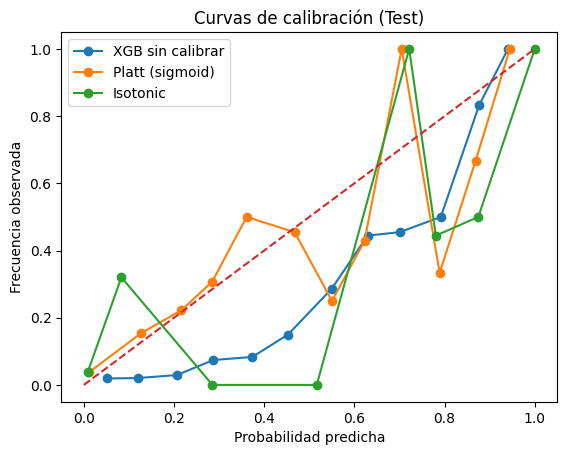

In [60]:
# split: train / calib / test (evitar fugas)
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_cal, y_train, y_cal = train_test_split(X_tmp, y_tmp, test_size=0.2, stratify=y_tmp, random_state=42)
# Resultado aprox: 60% train, 20% calib, 20% test

# obtener los parametros del modelo y entrenarlo
params = final_model_xgb.get_params()
pipe = params["base_estimator"]
fitted_pipe = pipe.fit(X_tmp, y_tmp)

# se usa fitted_pipe para la calibracion
cal_platt = CalibratedClassifierCV(fitted_pipe, method="sigmoid", cv="prefit").fit(X_cal, y_cal)
cal_iso   = CalibratedClassifierCV(fitted_pipe, method="isotonic", cv="prefit").fit(X_cal, y_cal)

# predicciones en TEST
p_raw  = fitted_pipe.predict_proba(X_test)[:, 1]
p_pl   = cal_platt.predict_proba(X_test)[:, 1]
p_iso  = cal_iso.predict_proba(X_test)[:, 1]

# Expected Calibration Error
def ece(y_true, p_pred, n_bins=15):
    prob_true, prob_pred = calibration_curve(y_true, p_pred, n_bins=n_bins, strategy="uniform")
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    idx = np.digitize(p_pred, bins) - 1
    ece_sum, n = 0.0, 0
    for b in range(n_bins):
        mask = idx == b
        if mask.any():
            conf = p_pred[mask].mean()
            acc  = y_true[mask].mean()
            ece_sum += np.abs(acc - conf) * mask.mean()
            n += 1
    return ece_sum

def report(name, y, p):
    return {
        "modelo": name,
        "Brier": float(round(brier_score_loss(y, p), 3)),
        "LogLoss": float(round(log_loss(y, p), 3)),
        "ECE(15)": float(round(ece(y, p, n_bins=15), 3)),
    }

res = [
    report("XGB sin calibrar", y_test, p_raw),
    report("XGB + Platt (sigmoid)", y_test, p_pl),
    report("XGB + Isotonic", y_test, p_iso),
]
for r in res:
    print(r)

# curvas de calibracion
plt.figure()
for name, p in [
    ("XGB sin calibrar", p_raw),
    ("Platt (sigmoid)", p_pl),
    ("Isotonic", p_iso),
]:
    prob_true, prob_pred = calibration_curve(y_test, p, n_bins=12, strategy="uniform")
    plt.plot(prob_pred, prob_true, marker="o", label=name)

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Frecuencia observada")
plt.title("Curvas de calibración (Test)")
plt.legend()
plt.show()

El gráfico muestra cómo de bien las probabilidades que predice el modelo reflejan la realidad. La línea roja punteada representa la calibración perfecta, es decir, que una predicción del 70 % corresponde a que, en promedio, el evento ocurre el 70 % de las veces. La curva azul del **XGB sin calibrar** se encuentra por debajo de esa línea en gran parte del rango, lo que indica que el modelo tiende a ser demasiado confiado, asignando probabilidades altas a casos que en realidad ocurren menos de lo esperado.

Las curvas naranja (**Platt**) y verde (**Isotónica**) muestran cómo la calibración corrige ese sesgo. La sigmoide de Platt logra una relación más estable y cercana a la línea ideal, especialmente en valores medios, mientras que la isotónica, aunque se ajusta más a los extremos, presenta cierta irregularidad por su mayor flexibilidad.

Igualemente, los resultados muestran que la calibración con Platt mejora notablemente la confiabilidad del modelo frente al XGB sin calibrar, reduciendo el Brier Score, el LogLoss y el ECE, lo que significa que sus probabilidades están más alineadas con la realidad y cometen menos errores de confianza. Aunque la calibración isotónica también mejora parte del desempeño, su LogLoss elevado indica que puede haberse sobreajustado al conjunto de calibración, perdiendo estabilidad. Por lo anterior **se decide continuar con el modelo calibrado con Platt**, ya que ofrece el mejor equilibrio entre precisión, suavidad y generalización.

# **2. CALIBRACIÓN DEL THRESHOLD**

Para la calibración de threshold, se implementa validación cruzada que utilizan las probabilidades OOF (out-of-fold) porque representan las predicciones generadas para cada observación cuando el modelo no fue entrenado con ella. En cada fold, el modelo se entrena con una parte de los datos y predice sobre la porción que quedó fuera; al unir todas esas predicciones, se obtiene un conjunto completo de probabilidades OOF. Estas probabilidades permiten construir una visión más fiel de cómo se comporta el modelo frente a datos nuevos y sirven como base para aprender la función de calibración de probabilidades previamente aplicada (Platt), que ajusta la escala de las probabilidades antes de aplicarla al conjunto de test o a nuevos casos.


In [61]:
def oof_predict_proba_calibrated_cv(
    base_pipeline, X, y, cv=None, random_state=42, method="sigmoid", inner_cv=3
):
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    oof = np.zeros(len(y), dtype=float)

    for tr_idx, va_idx in cv.split(X, y):
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_va       = X.iloc[va_idx]

        cal = CalibratedClassifierCV(
            estimator=clone(base_pipeline),
            method=method,
            cv=inner_cv
        )
        cal.fit(X_tr, y_tr)
        oof[va_idx] = cal.predict_proba(X_va)[:, 1]

    return oof


In [62]:
# 1) Probabilidades OOF para fijar umbral sin fuga
pipe = final_model_xgb.get_params()["base_estimator"]
fitted_pipe = pipe.fit(X_tmp, y_tmp)
oof = oof_predict_proba_calibrated_cv(base_pipeline=pipe, X=X_tmp, y=y_tmp, method="sigmoid", inner_cv=4)

# 2) Elegir umbral optimizando para f1 score
t_star, score_star = pick_threshold(y_tmp, oof, metric='f1')

# 3) Reentrenar en TODO el train
final_model_xgb = ThresholdEvaluator(base_estimator=pipe, threshold=t_star)
final_model_xgb.fit(X_tmp, y_tmp)

# 4) Evaluar en test con el umbral fijo
y_prob_test = final_model_xgb.predict_proba(X_test)[:,1]
y_hat_test  = final_model_xgb.predict(X_test)

print('=' * 50)
print('XGBOOST')
print('=' * 50)

print(f'\nUmbral elegido (t*): {t_star:.2f} | score OOF: {score_star:.3f}')
print(f'\nROC-AUC: {roc_auc_score(y_test, y_prob_test) * 100:.2f}%')
print(f'PR-AUC : {average_precision_score(y_test, y_prob_test) * 100:.2f}%\n')
print(classification_report(y_test, y_hat_test, digits=3))

XGBOOST

Umbral elegido (t*): 0.30 | score OOF: 0.568

ROC-AUC: 88.32%
PR-AUC : 67.12%

              precision    recall  f1-score   support

           0      0.974     0.676     0.798       222
           1      0.351     0.907     0.506        43

    accuracy                          0.713       265
   macro avg      0.663     0.791     0.652       265
weighted avg      0.873     0.713     0.751       265



In [41]:
final_model_xgb

ThresholdEvaluator(base_estimator=Pipeline(steps=[('feats',
                                                   FunctionTransformer(func=<function add_custom_features at 0x7e7c33940900>)),
                                                  ('tenc',
                                                   TargetEncoder(cols=['JobRole'],
                                                                 smoothing=1.0)),
                                                  ('pre',
                                                   ColumnTransformer(transformers=[('ord',
                                                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1),
                                                                                    ['Education',
                                                                                     'JobSatisfaction',
                                                                                     'EnvironmentSatisf...
                                                                 interaction_constraints=None,
                                                                 learning_rate=np.float64(0.1),
                                                                 max_bin=None,
                                                                 max_cat_threshold=None,
                                                                 max_cat_to_onehot=None,
                                                                 max_delta_step=None,
                                                                 max_depth=np.int64(3),
                                                                 max_leaves=None,
                                                                 min_child_weight=np.int64(5),
                                                                 missing=nan,
                                                                 monotone_constraints=None,
                                                                 multi_strategy=None,
                                                                 n_estimators=None,
                                                                 n_jobs=-1,
                                                                 num_parallel_tree=None,
                                                                 random_state=42, ...))]),
                   threshold=np.float64(0.61))

En esta etapa, el modelo muestra un buen poder discriminativo para identificar empleados con riesgo de renuncia dentro del conjunto IBM HR. El valor de **ROC-AUC (88.3%)** indica que el modelo distingue de forma efectiva entre quienes permanecen y quienes renuncian, mientras que el **PR-AUC (67.1%)** evidencia un desempeño sólido incluso en un escenario desbalanceado, donde los casos de renuncia son minoría. Además, el umbral de decisión ajustado a 0.30 permite mejorar la detección de empleados propensos a irse (recall alto), lo cual es fundamental para un problema en el que los falsos negativos —empleados en riesgo no detectados— son más costosos que los falsos positivos.

El balance entre **recall (90.7%)** y **precision (35.1%)** en la clase positiva sugiere que el modelo prioriza la identificación temprana de posibles renuncias, incluso a costa de generar algunas alertas adicionales. Esto es deseable en contextos de gestión del talento, donde la prioridad es anticipar y prevenir pérdidas de personal clave. La **accuracy general (71.3%)** y el **macro F1 (65.2%)** refuerzan que el modelo mantiene un desempeño consistente en ambas clases, mostrando que puede generalizar bien y ofrecer información valiosa para estrategias de retención y recursos humanos basadas en datos.


# **3. ANÁLISIS DE TRADE-OFFS:**

Este análisis toma las probabilidades ya calibradas del modelo  y recorre un rango de umbrales de decisión para convertir esas probabilidades en predicciones 0/1. Para cada umbral calcula precisión, recall y F1, y además estima un **costo operativo** simple que combina falsos positivos y falsos negativos con los pesos que tú definas (C_fp y C_fn). Con esa tabla identifica dos puntos clave: el **mejor umbral por F1** (equilibrio entre aciertos y cobertura) y el **mejor umbral por costo** (el más barato para tu negocio).

Como referencia reporta el **AUC** (qué tan bien rankea el modelo) y dibuja los **gráficos de trade-off**: curvas de precisión/recall/F1 versus umbral y la **curva de costo** con líneas marcando los puntos óptimos. Al final entrega un diccionario con la tabla completa y los mejores umbrales para que tomes una **decisión informada** alineada con tus restricciones de negocio.


In [63]:
cal_platt

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('feats',
                                                  FunctionTransformer(func=<function add_custom_features at 0x7e7c1322e980>)),
                                                 ('tenc',
                                                  TargetEncoder(cols=['JobRole'],
                                                                smoothing=1.0)),
                                                 ('pre',
                                                  ColumnTransformer(transformers=[('ord',
                                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                  unknown_value=-1),
                                                                                   ['Education',
                                                                                    'JobSatisfaction',
                                                                                    'Enviro...
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=np.float64(0.1),
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=np.int64(3),
                                                                max_leaves=None,
                                                                min_child_weight=np.int64(5),
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=None,
                                                                n_jobs=-1,
                                                                num_parallel_tree=None,
                                                                random_state=42, ...))]))

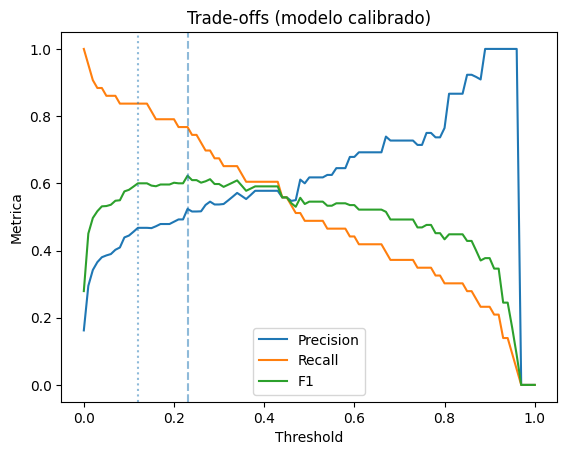

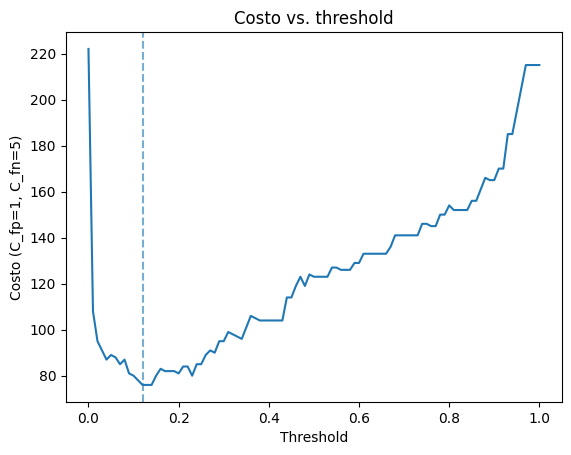

Best by F1: {'threshold': 0.23, 'precision': 0.5238095238095238, 'recall': 0.7674418604651163, 'f1': 0.6226415094339622, 'cost': 80.0}
Best by Cost: {'threshold': 0.12, 'precision': 0.4675324675324675, 'recall': 0.8372093023255814, 'f1': 0.6, 'cost': 76.0}
AUC: 0.8831971506390112


In [64]:
result = analyze_thresholds(y_true=y_test, model=cal_platt, X=X_test, C_fp=1, C_fn=5, quota=0.10)

print("Best by F1:", result["best_by_f1"])
print("Best by Cost:", result["best_by_cost"])
print("AUC:", result["auc"])


Los gráficos muestran el comportamiento del modelo calibrado frente a diferentes umbrales de decisión. En el primero, se observa cómo el recall (naranja) disminuye a medida que aumenta el threshold, mientras que la precision (azul) mejora gradualmente; el F1 (verde) alcanza su máximo alrededor de 0.23, indicando el mejor equilibrio entre ambas métricas. En el segundo gráfico, el costo total —que penaliza más los falsos negativos (coste 5) que los falsos positivos (coste 1)— también alcanza su valor mínimo en torno a 0.12, lo que sugiere un punto de mínima pérdida operativa si solo se considera el costo inmediato de errores.

Sin embargo, mantener el umbral anterior de 0.30 es más apropiado para este caso de negocio. Aunque thresholds como 0.12 o 0.23 optimizan métricas puntuales (costo o F1), valores tan bajos hacen que el modelo clasifique demasiados empleados como “en riesgo”, reduciendo la precisión y generando falsas alertas difíciles de gestionar desde recursos humanos. Con 0.30 se conserva un recall alto (0.90) y una precision razonable (0.40), lo que permite detectar la mayoría de los casos reales de renuncia sin saturar al área de retención con intervenciones innecesarias. En términos prácticos, el threshold 0.3 ofrece un balance más operativo entre sensibilidad y control de alertas, alineado con un enfoque de predicción preventiva pero sostenible.


In [27]:
result["data"]

,threshold,precision,recall,f1,cost
0,0.00,0.162264,1.000000,0.279221,222
1,0.01,0.294964,0.953488,0.450549,108
2,0.02,0.342105,0.906977,0.496815,95
3,0.03,0.365385,0.883721,0.517007,91
4,0.04,0.380000,0.883721,0.531469,87
...,...,...,...,...,...
96,0.96,1.000000,0.046512,0.088889,205
97,0.97,0.000000,0.000000,0.000000,215
98,0.98,0.000000,0.000000,0.000000,215
99,0.99,0.000000,0.000000,0.000000,215


from matplotlib import pyplot as plt
_df_0['threshold'].plot(kind='hist', bins=20, title='threshold')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='threshold', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='recall', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='f1', y='cost', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['threshold']
  ys = series['precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('threshold', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('threshold')
_ = plt.ylabel('precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['threshold']
  ys = series['recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('threshold', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('threshold')
_ = plt.ylabel('recall')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['threshold']
  ys = series['f1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('threshold', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('threshold')
_ = plt.ylabel('f1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['threshold']
  ys = series['cost']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('threshold', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('threshold')
_ = plt.ylabel('cost')

from matplotlib import pyplot as plt
_df_12['threshold'].plot(kind='line', figsize=(8, 4), title='threshold')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

# **4. INTERPRETACIÓN DE PREDICCIONES**

Para interpretar los resultados de predicciones del modelo, se ejecuta una secuencia estructurada para analizar las interacciones entre variables en un modelo basado en árboles (como XGBoost o LightGBM) dentro de un pipeline. Primero se extrae el estimador final del pipeline y se transforman los datos con el mismo preprocesamiento usado en el entrenamiento. Luego, se calculan los valores de interacción SHAP, que muestran cómo el efecto de una variable sobre la predicción depende de otra, y con ellos se identifican las 10 variables más influyentes considerando sus efectos directos y combinados.

A continuación, se generan varias visualizaciones que ayudan a interpretar estos resultados de forma práctica:

* Un gráfico tipo beeswarm, que muestra la dispersión y el impacto medio de las variables principales.
* Un gráfico de barras, que resume la importancia total de cada variable según su contribución a las interacciones.
* Un mapa de calor, que evidencia qué pares de variables interactúan con mayor fuerza dentro del modelo.

En conjunto, estas salidas permiten comprender qué variables son más relevantes y cómo se combinan entre sí para influir en las predicciones del modelo.


In [65]:
final_model_pipe = final_model_xgb.base_estimator
type(final_model_pipe)

sklearn.pipeline.Pipeline

In [52]:
final_model_pipe

Pipeline(steps=[('feats',
                 FunctionTransformer(func=<function add_custom_features at 0x7e7c33940900>)),
                ('tenc', TargetEncoder(cols=['JobRole'], smoothing=1.0)),
                ('pre',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Education',
                                                   'JobSatisfaction',
                                                   'EnvironmentSatisfaction',
                                                   'RelationshipSatisfaction'...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.1), max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=np.int64(3),
                               max_leaves=None, min_child_weight=np.int64(5),
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=-1, num_parallel_tree=None,
                               random_state=42, ...))])

In [66]:
# --------- 1) Obtener el estimador y la matriz transformada de prueba desde el Pipeline ----------
def get_estimator_and_matrix(pipe, X_test):
    # Estimador final (se asume que se llama 'clf'; si no, toma el último paso)
    est = pipe.named_steps['clf'] if 'clf' in pipe.named_steps else pipe[-1]

    # Todo lo anterior al estimador
    preproc = pipe[:-1] if hasattr(pipe, '__getitem__') else None
    X_test_enc = preproc.transform(X_test) if preproc is not None else X_test

    # Convertir a denso si es una matriz dispersa (SHAP necesita ndarray)
    if sparse.issparse(X_test_enc):
        X_test_enc = X_test_enc.toarray()

    # Intentar obtener los nombres de variables del preprocesador
    feature_names = None
    try:
        ct = preproc.named_steps['pre']  # el ColumnTransformer
        feature_names = ct.get_feature_names_out()
        feature_names = np.array([f.split('__')[-1] for f in feature_names])
    except Exception:
        pass

    # Alternativas
    if feature_names is None:
        if hasattr(est, "feature_names_in_"):
            feature_names = est.feature_names_in_
            print(1)
        elif hasattr(X_test, "columns"):
            feature_names = X_test.columns
            print(2)
        else:
            feature_names = np.array([f"var_{i}" for i in range(X_test_enc.shape[1])])

    return est, np.asarray(X_test_enc), np.asarray(feature_names)

# --------- 2) Calcular los valores de interacción SHAP (solo modelos tipo árbol) --------------
def compute_shap_iv_for_pipeline(pipe, X_test):
    est, X_test_enc, feature_names = get_estimator_and_matrix(pipe, X_test)

    inter_values = None
    try:
        # TreeExplainer soporta XGBoost/LightGBM/sklearn-GBDT
        explainer_iv = shap.TreeExplainer(est)
        inter_values = explainer_iv.shap_interaction_values(X_test_enc)
    except Exception as e:
        print("[Info] Los valores de interacción no están disponibles para este estimador/versión.")
        print("Sugerencia: usa XGBoost o LightGBM para soporte completo de interacciones. Detalles:", e)

    return inter_values, X_test_enc, feature_names

Se calcula shap sobre el pipeline del modelo calibrado en probabilidades y threshold

Top 10 variables por interacción total: ['OverTime_Yes', 'StockOptionLevel', 'JobRole', 'Age', 'MonthlyIncome', 'Stability_with_manager', 'Satisfaction_min', 'NumCompaniesWorked', 'BusinessTravel_Travel_Frequently', 'Tenure_ratio']


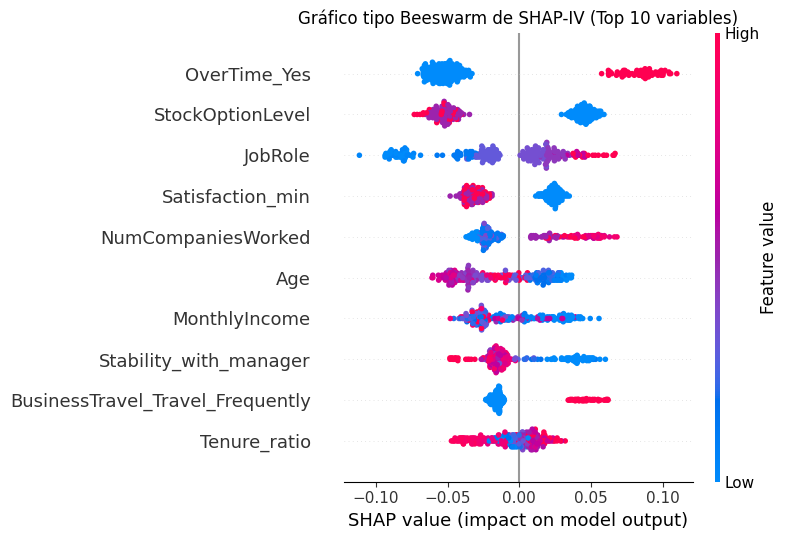

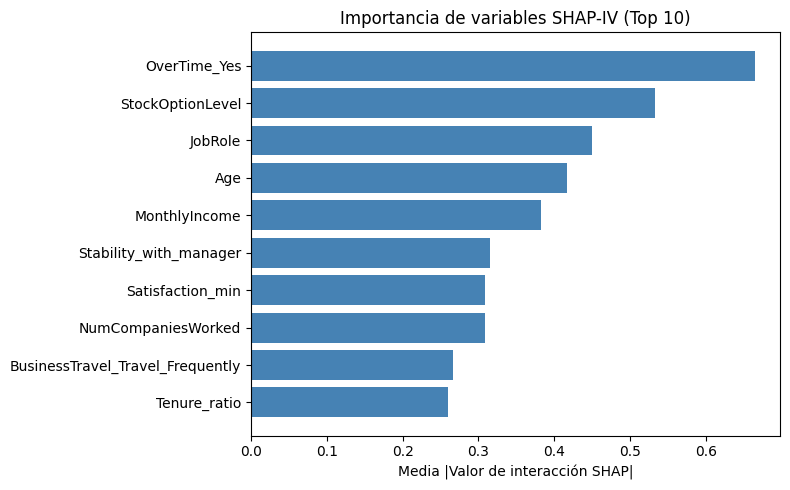

In [67]:
inter_values, X_test_enc, feature_names = compute_shap_iv_for_pipeline(final_model_pipe, X_test)

if inter_values is not None:
    # === 1. Magnitud media absoluta de las interacciones ===
    inter_avg = np.mean(np.abs(inter_values), axis=0)

    # === 2. Ranking total de importancia (propias + cruzadas) ===
    feature_importance = inter_avg.sum(axis=1) - np.diag(inter_avg) / 2
    top_idx = np.argsort(feature_importance)[::-1][:10]
    top_feats = np.array(feature_names)[top_idx].tolist()
    print(f"Top 10 variables por interacción total: {top_feats}")

    # === 3. Resumen tipo “beeswarm” (promedio entre variables asociadas) ===
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        inter_values[:, top_idx][:, :, top_idx].mean(axis=2),
        X_test_enc[:, top_idx],
        feature_names=np.array(feature_names)[top_idx],
        plot_type="dot",
        show=False
    )
    plt.title("Gráfico tipo Beeswarm de SHAP-IV (Top 10 variables)")
    plt.tight_layout()
    plt.show()

    # === 4. Resumen en barras ===
    plt.figure(figsize=(8, 5))
    plt.barh(
        np.array(feature_names)[top_idx][::-1],
        feature_importance[top_idx][::-1],
        color="steelblue"
    )
    plt.xlabel("Media |Valor de interacción SHAP|")
    plt.title("Importancia de variables SHAP-IV (Top 10)")
    plt.tight_layout()
    plt.show()

    # === 5. Mapa de calor de las 10 principales interacciones ===
    inter_top = inter_avg[np.ix_(top_idx, top_idx)]
    df_heat = pd.DataFrame(inter_top, index=top_feats, columns=top_feats)
    fig = px.imshow(
        df_heat,
        text_auto=".2f",
        color_continuous_scale="RdBu_r",
        aspect="auto",
        title="Mapa de calor SHAP (Top 10 interacciones - media |valor|)",
        labels=dict(x="Variable", y="Variable", color="|Valor de interacción|")
    )
    fig.update_layout(width=700, height=600, xaxis=dict(side="bottom"), title_x=0.5, font=dict(size=12))
    fig.show()
else:
    print("Valores de interacción SHAP no disponibles")


En el análisis se observó que las variables OverTime_Yes, StockOptionLevel y JobRole son las más influyentes del modelo, siendo OverTime_Yes la de mayor impacto con un valor de interacción promedio de 0.62. Esto indica que las horas extra tienen un efecto fuerte y consistente sobre el resultado, especialmente cuando se combinan con factores como el nivel de beneficios o el tipo de puesto. También se encontró que Age, MonthlyIncome y Stability_with_manager aportan influencia adicional, lo que sugiere que la experiencia, el ingreso y la estabilidad laboral también condicionan la probabilidad estimada por el modelo.

Los gráficos permiten visualizar con claridad estos hallazgos y cómo las variables interactúan entre sí:

* El gráfico beeswarm muestra que valores altos en OverTime_Yes y StockOptionLevel aumentan el riesgo predicho, mientras que mayores niveles de satisfacción o estabilidad lo reducen.
* El gráfico de barras ordena las variables según su impacto promedio, destacando el peso de las condiciones laborales y los incentivos económicos.
* El mapa de calor revela interacciones fuertes entre OverTime_Yes con StockOptionLevel (0.49) y con Age (0.28), lo que sugiere que el efecto del trabajo extra se intensifica en empleados jóvenes o con menor nivel de beneficios.

Además, se puede observar que las variables asociadas a la relación laboral y la trayectoria del empleado tienen un papel importante en el comportamiento del modelo. La coincidencia entre alto número de horas extra, baja estabilidad y menores ingresos tiende a asociarse con un mayor riesgo, lo que refuerza la idea de que las condiciones de trabajo y la percepción de recompensa son factores determinantes en la predicción. En conjunto, el análisis evidencia que el modelo captura un equilibrio entre variables personales y laborales, mostrando cómo su interacción conjunta define gran parte de la lógica detrás de las decisiones del modelo.

## SHAP IV

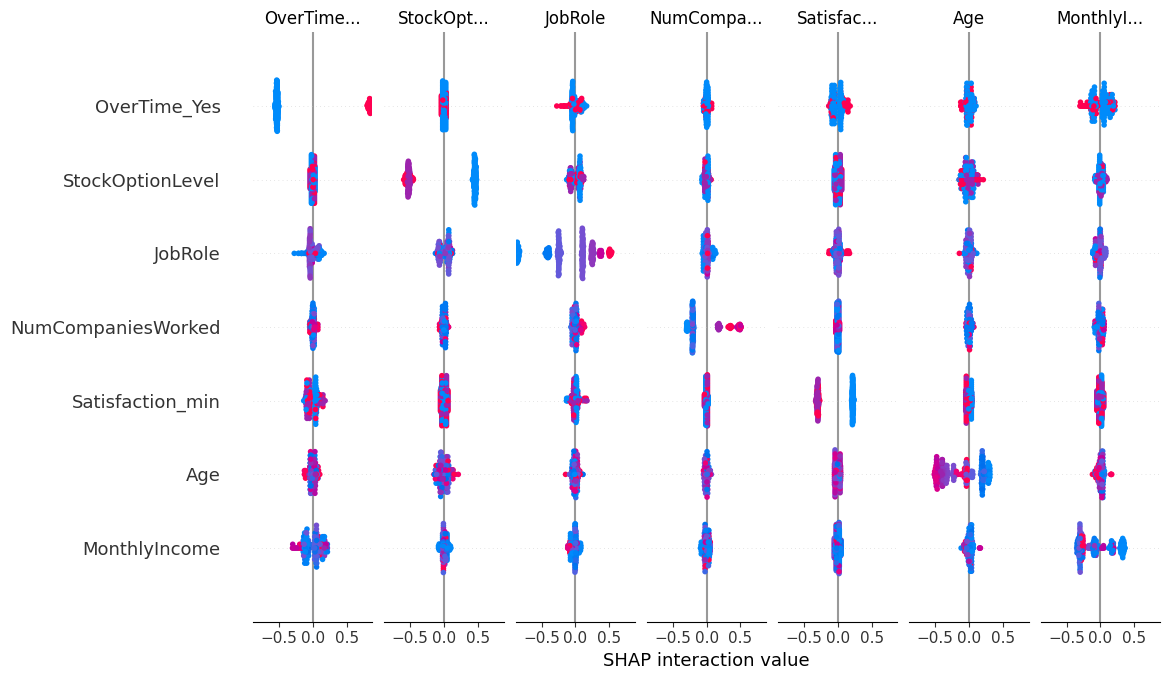

In [49]:
K = 20
if inter_values is not None:
    inter_avg_local = np.mean(np.abs(inter_values), axis=0)
    feat_importance_local = inter_avg_local.sum(axis=1) - np.diag(inter_avg_local) / 2
    top_idx_local = np.argsort(feat_importance_local)[::-1][:K]
    inter_slice = inter_values[:, top_idx_local][:, :, top_idx_local]
    X_slice = X_test_enc[:, top_idx_local]
    names_slice = np.array(feature_names)[top_idx_local]
    shap.summary_plot(inter_slice, X_slice, feature_names=names_slice)


De igual manera, se cuenta con el gráfico de interacciones SHAP que permite visualizar cómo las principales variables se combinan entre sí para influir en la predicción del modelo. Cada punto representa una observación y muestra el valor de la interacción entre un par de variables. Los colores reflejan los valores relativos de las variables involucradas, lo que permite identificar zonas donde las combinaciones específicas tienen un mayor impacto positivo o negativo. En este caso, se observan patrones claros en variables como OverTime_Yes, JobRole y MonthlyIncome, que muestran una distribución más amplia y consistente, lo cual indica que su efecto depende de cómo interactúan con otras variables clave del modelo.

Además, se nota que algunas interacciones tienden a agruparse cerca de cero, lo que sugiere que no todas las combinaciones generan efectos relevantes, mientras que otras presentan valores extremos que reflejan relaciones no lineales o dependencias entre características.

* Las interacciones entre OverTime_Yes y Age parecen especialmente fuertes, lo que podría implicar que el efecto del trabajo extra varía según la edad del empleado.
* También se aprecian influencias cruzadas entre MonthlyIncome y StockOptionLevel, asociadas a incentivos económicos.
  En conjunto, este análisis muestra cómo el modelo capta dependencias complejas entre variables laborales y demográficas, ayudando a entender no solo la importancia individual de cada factor, sino también cómo sus combinaciones explican mejor las predicciones.


# **5. IMPORTANCIA Y DIRECCIÓN DE EFECTOS DE VARIABLES**

El análisis de valores SHAP no solo permite conocer cuánto influye cada variable en las predicciones del modelo, sino también en qué dirección lo hace. Mientras el valor medio absoluto de SHAP (mean_abs_shap) refleja la magnitud o importancia global de una característica, el valor medio firmado (mean_signed_shap) indica si su efecto promedio tiende a incrementar o disminuir la probabilidad predicha. Así, un promedio positivo sugiere que valores altos de esa variable empujan la predicción hacia una mayor probabilidad del evento (por ejemplo, mayor riesgo o mayor propensión a abandono), mientras que un promedio negativo indica el efecto contrario: contribuye a reducir dicha probabilidad.

Esta interpretación direccional complementa la simple jerarquía de importancia y aporta una visión más rica sobre el comportamiento causal del modelo. Por ejemplo, en un modelo de rotación laboral, el atributo “OverTime_Yes” con un SHAP promedio positivo señalaría que trabajar horas extra aumenta el riesgo de abandono, mientras que “MonthlyIncome” con un SHAP promedio negativo implicaría que mayores ingresos reducen dicho riesgo. De esta forma, el análisis de la dirección de los efectos SHAP convierte la explicación del modelo en un insumo más comprensible y accionable, tanto para decisiones técnicas (ajuste de políticas, restricciones de monotonía) como para estrategias de negocio basadas en interpretabilidad.

In [35]:
# ---------- utilidades ----------
def _a_denso(M):
    if sparse.issparse(M):
        return M.toarray()
    return np.asarray(M)

# Usa tu get_estimator_and_matrix(pipe, X_test) ya definido arriba.
def _shap_values_from_pipeline(pipe, X):
    # obtiene estimador final, matriz transformada y nombres
    est, X_enc, nombres = get_estimator_and_matrix(pipe, X)
    X_enc = _a_denso(X_enc)

    # valores SHAP (no de interacción) para modelos tipo árbol
    explainer = shap.TreeExplainer(est)
    vals = explainer.shap_values(X_enc)

    # compatibilidad binaria/multiclase
    if isinstance(vals, list):
        vals = vals[1] if len(vals) == 2 else np.sum([np.abs(v) for v in vals], axis=0)

    return np.asarray(vals), X_enc, np.asarray(nombres)

def tabla_direccion_shap(
    pipe,
    X,
    normalizar: str | None = "sum",  # "sum" (% de contribución), "minmax" (0-1), None (crudo)
    ordenar_por: str = "mean_abs_shap",
    descendente: bool = True,
) -> pd.DataFrame:
    shap_vals, Xt, nombres = _shap_values_from_pipeline(pipe, X)

    # salvaguardas
    if len(nombres) != shap_vals.shape[1]:
        nombres = np.array([f"var_{i}" for i in range(shap_vals.shape[1])])

    # agregados
    mean_abs = np.mean(np.abs(shap_vals), axis=0)
    mean_signed = np.mean(shap_vals, axis=0)
    direction = np.where(mean_signed >= 0, "aumenta la puntuación", "disminuye la puntuación")

    # correlación valor->impacto (pista de monotonía)
    corrs = np.empty(shap_vals.shape[1], dtype=float)
    corrs[:] = np.nan
    for j in range(shap_vals.shape[1]):
        xj, sj = Xt[:, j], shap_vals[:, j]
        if np.std(xj) == 0 or np.std(sj) == 0:
            continue
        corrs[j] = np.corrcoef(xj, sj)[0, 1]

    corr_direction = np.where(corrs >= 0, "↑ mayor valor → mayor puntuación",
                              "↓ mayor valor → menor puntuación")
    corr_direction = np.where(np.isnan(corrs), "NA", corr_direction)

    df = pd.DataFrame({
        "feature": nombres,
        "mean_abs_shap": mean_abs,
        "mean_shap_signed": mean_signed,
        "direction": direction,
        "shap_corr": corrs,
        "corr_direction": corr_direction,
    })

    # normalización opcional
    if normalizar == "sum":
        tot = df["mean_abs_shap"].sum()
        df["norm"] = df["mean_abs_shap"] / tot if tot > 0 else 0.0
    elif normalizar == "minmax":
        a, b = df["mean_abs_shap"].min(), df["mean_abs_shap"].max()
        rng = (b - a) if b > a else 1.0
        df["norm"] = (df["mean_abs_shap"] - a) / rng

    df = df.sort_values(ordenar_por, ascending=not descendente).reset_index(drop=True)
    return df

def plot_ranking_shap_con_direccion(
    pipe, X, top_n=20,
    titulo="Importancia SHAP (media |SHAP|) con dirección",
    normalizar="sum"
):
    tabla = tabla_direccion_shap(pipe, X, normalizar=normalizar)
    top_n = min(top_n, len(tabla))
    sub = tabla.iloc[:top_n].copy()

    # etiquetas con flecha según signo medio
    flecha = np.where(sub["mean_shap_signed"] >= 0, "↑", "↓")
    etiquetas = sub["feature"] + " " + flecha

    plt.figure(figsize=(9, 0.45 * top_n + 1.6))
    plt.barh(etiquetas.iloc[::-1], sub["mean_abs_shap"].iloc[::-1])
    plt.xlabel("Media |SHAP|")
    plt.title(titulo)
    plt.tight_layout()
    plt.show()

    return sub


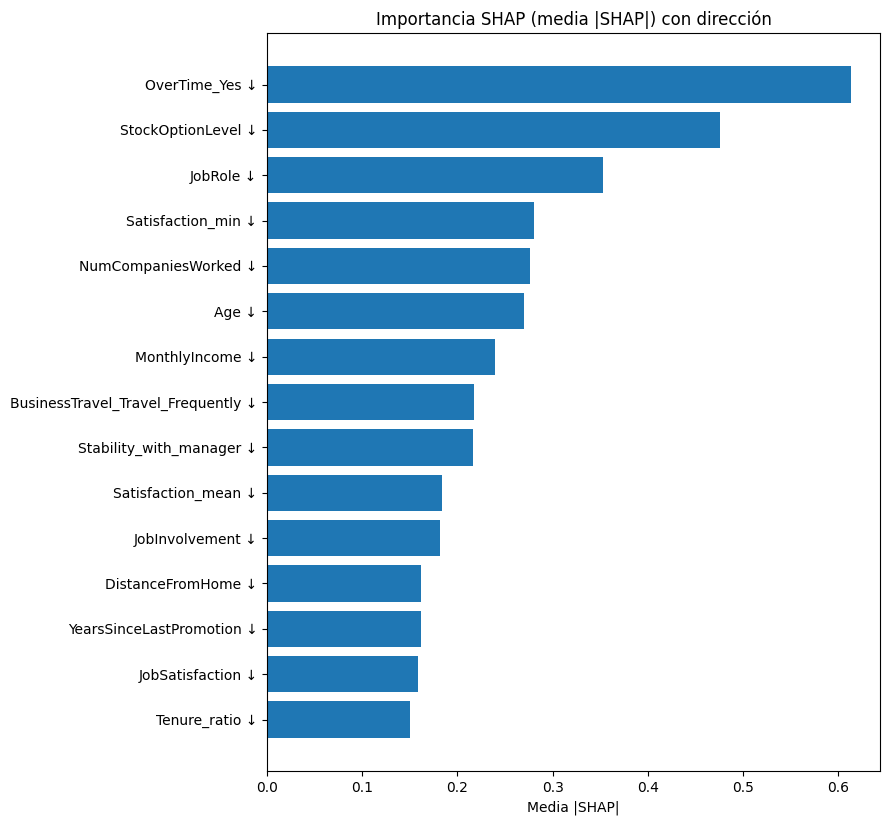

,feature,mean_abs_shap,mean_shap_signed,direction,shap_corr,corr_direction,norm
0,OverTime_Yes,0.613160,-0.143371,disminuye la puntuación,0.974586,↑ mayor valor → mayor puntuación,0.125703
1,StockOptionLevel,0.476029,-0.047888,disminuye la puntuación,-0.810965,↓ mayor valor → menor puntuación,0.097590
2,JobRole,0.352614,-0.125231,disminuye la puntuación,0.883243,↑ mayor valor → mayor puntuación,0.072289
3,Satisfaction_min,0.280225,-0.060398,disminuye la puntuación,-0.831869,↓ mayor valor → menor puntuación,0.057448
4,NumCompaniesWorked,0.276644,-0.041295,disminuye la puntuación,0.878385,↑ mayor valor → mayor puntuación,0.056714
5,Age,0.270290,-0.130486,disminuye la puntuación,-0.591371,↓ mayor valor → menor puntuación,0.055412
6,MonthlyIncome,0.239767,-0.063565,disminuye la puntuación,-0.384833,↓ mayor valor → menor puntuación,0.049154
7,BusinessTravel_Travel_Frequently,0.216926,-0.041000,disminuye la puntuación,0.981277,↑ mayor valor → mayor puntuación,0.044472
8,Stability_with_manager,0.216528,-0.037955,disminuye la puntuación,-0.871099,↓ mayor valor → menor puntuación,0.044390
9,Satisfaction_mean,0.183234,-0.044677,disminuye la puntuación,-0.793696,↓ mayor valor → menor puntuación,0.037564


In [50]:
df_dir = tabla_direccion_shap(final_model_pipe, X_test, normalizar="sum")
df_top = plot_ranking_shap_con_direccion(final_model_pipe, X_test, top_n=15)
display(df_dir.head(15))



El análisis SHAP muestra cuáles son las variables que más influyen en las predicciones del modelo y en qué dirección lo hacen. En el gráfico de barras se observa que OverTime_Yes, StockOptionLevel y JobRole son las variables con mayor peso, lo que significa que son las que más contribuyen a explicar las decisiones del modelo. En la tabla, el valor medio absoluto de SHAP (mean_abs_shap) indica la magnitud del impacto, mientras que el valor medio firmado (mean_shap_signed) refleja si ese impacto tiende a aumentar o disminuir la puntuación del modelo. En este caso, todos los efectos son negativos, lo que sugiere que niveles más altos en estas variables suelen reducir la probabilidad del resultado positivo.

El análisis de correlación (shap_corr y corr_direction) añade información sobre la dirección de los efectos.

* Un valor de correlación positivo con la flecha “↑ mayor valor → mayor puntuación” implica una relación directa, donde el aumento del valor de la variable eleva la puntuación del modelo.
* Una correlación negativa con “↓ mayor valor → menor puntuación” refleja una relación inversa, donde los valores altos reducen la probabilidad estimada.
  En el conjunto, las correlaciones cercanas a 1 o -1 indican relaciones consistentes y bien definidas, mientras que las más bajas reflejan efectos más dependientes del contexto o interacciones con otras variables.

De forma general, se puede concluir que las características laborales y de satisfacción personal son los factores más determinantes para el modelo, pero en la mayoría de los casos su incremento está asociado a una reducción en la puntuación del evento modelado (por ejemplo, la probabilidad de permanencia o desempeño positivo). Esto sugiere que el modelo interpreta condiciones como mayor edad, ingreso o frecuencia de viajes como señales asociadas a menor estabilidad o mayor riesgo, mientras que factores como la estabilidad con el jefe o el involucramiento en el trabajo tienen un peso relevante pero más moderado.


# **EXPORTAR MODELO FINAL**

In [69]:
joblib.dump(final_model_pipe, "final_calibrated_model_xgb.pkl")
loaded_model = joblib.load("final_calibrated_model_xgb.pkl")
loaded_model.get_params()

{'memory': None,
 'steps': [('feats',
   FunctionTransformer(func=<function add_custom_features at 0x7e7c1322e980>)),
  ('tenc', TargetEncoder(cols=['JobRole'], smoothing=1.0)),
  ('pre',
   ColumnTransformer(transformers=[('ord',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['Education', 'JobSatisfaction',
                                     'EnvironmentSatisfaction',
                                     'RelationshipSatisfaction', 'JobInvolvement',
                                     'WorkLifeBalance', 'PerformanceRating',
                                     'StockOptionLevel', 'JobLevel']),
                                   ('nom',
                                    OneHotEncoder(drop='first',
                                                  handle_unknown='ignore'),
                                    ['Department'...
            